# &emsp;&emsp; &emsp;&emsp;&emsp;Human Protein Atlas - Single Cell Classification

### Introduction:

&emsp;&emsp;&emsp; Human body consists of trillions of cells but also not all humans have the same kind of cells. Location of protein is very important in cells and hence dissimilarity in location of protein can breed cellular heterogeneity. For cellular processes/operations protein plays a crucial role, Collection of proteins come together at some discrete location to perform some task and outcome of this task is based on which kind of protein are present. From this different subcellular dispensation of one protein can give rise to great functional differences, finding such differences and figuring out why and how they occur, is important for understanding how cells function, how diseases develop, and ultimately how to develop better treatments for those diseases.   
    
&emsp;&emsp;&emsp; This is a supervised multi-label classification problem. Given images of cells from the microscopes and given labels of protein location assigned together for all the cells in the image. In this notebook We have developed a model which is capable of segmenting and classifying each individual cell with precise labels.

In [1]:
!pip install ../input/hpa-library-install/iterative-stratification-master/iterative-stratification-master
!pip install ../input/hpa-library-install/pytorch_zoo-master/pytorch_zoo-master
!pip install ../input/hpa-library-install/HPA-Cell-Segmentation-master/HPA-Cell-Segmentation-master

Processing /kaggle/input/hpa-library-install/iterative-stratification-master/iterative-stratification-master
  Created wheel for iterative-stratification: filename=iterative_stratification-0.1.6-py3-none-any.whl size=8406 sha256=9b942274f1b38f04072277306dd8d582c1e4abdbfc411e9c251d9534e0fa686f
  Stored in directory: /root/.cache/pip/wheels/87/7c/2c/59c2b79eba16311b91909e6a489bd937eef6147db4fd4891dd
Successfully built iterative-stratification
Processing /kaggle/input/hpa-library-install/pytorch_zoo-master/pytorch_zoo-master
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=01b0e18b5c7971d6d8f1d77f332549208e97603380e33e44fa393b97a673489a
  Stored in directory: /root/.cache/pip/wheels/06/71/e7/ebe848d867080c250cfc2ae9419557fac9b3c646e028a27fff
Successfully built pytorch-zoo
Processing /kaggle/input/hpa-library-install/HPA-Cell-Segmentation-master/HPA-Cell-Segmentation-master
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.

In [2]:
# importing required libraries for basic operations
import pandas as pd       # for dataset processing 
import numpy as np        # for mathemetical processes
import pickle             # for files read and write operations
import os                 # for system related operations
import zipfile            # for zip files read and write operations
from tqdm import tqdm     # for displaying progress bar
import cv2                # for image processing
from PIL import Image     # for image processing

# importing required libraries for plotting
import matplotlib.pyplot as plt        
import plotly.graph_objects as go
import plotly.express as px

# importing required libraries for model creation 
from fastai.vision.all import *                                   # deep learning library

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold    # library for sampling dataset
import warnings
warnings.filterwarnings("ignore")

### Data:

&emsp;&emsp;&emsp; We have train data for training and test data for testing our model. In training data we have a directory containing all the images for training purpose and a csv file containing labels for all images.

### Train Data:

In [3]:
# loading train.csv file into a dataframe
train_df = pd.read_csv('../input/hpa-single-cell-image-classification/train.csv')
print('(rows, columns)',train_df.shape)
train_df.head()

(rows, columns) (21806, 2)


,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


### Train Data Description

&emsp;&emsp;&emsp; There are 2 columns and 21806 records in train.csv file.  
   
1. **ID**:- Contains Image files name    
2. **Label**:- Contains corresponding labels for each image file. There total 19 labels from 0-18. Following are their means

In [4]:
pd.read_csv('../input/additional-data/Labels.csv').style.hide_index()

Label,Name,Description
0,Nucleoplasm,The nucleus is found in the center of cell and can be identified with the help of the signal in the blue nucleus channel. A staining of the nucleoplasm may include the whole nucleus or of the nucleus without the regions known as nucleoli (Class 2).
1,Nuclear membrane,The nuclear membrane appears as a thin circle around the nucleus. It is not perfectly smooth and sometimes it is also possible to see the folds of the membrane as small circles or dots inside the nucleus.
2,Nucleoli,"Nucleoli can be seen as slightly elongated circular areas in the nucleoplasm, which usually display a much weaker staining in the blue DAPI channel. The number and size of nucleoli varies between cell types."
3,Nucleoli fibrillar center,"Nucleoli fibrillary center can appear as a spotty cluster or as a single bigger spot in the nucleolus, depending on the cell type."
4,Nuclear speckles,Nuclear speckles can be seen as irregular and mottled spots inside the nucleoplasm.
5,Nuclear bodies,"Nuclear bodies are visible as distinct spots in the nucleoplasm. They vary in shape, size and numbers depending on the type of bodies as well as cell type, but are usually more rounded compared to nuclear speckles."
6,Endoplasmic reticulum,"The endoplasmic reticulum (ER) is recognized by a network-like staining in the cytosol, which is usually stronger close to the nucleus and weaker close to the edges of the cell. The ER can be identified with the help of the staining in the yellow ER channel."
7,Golgi apparatus,"The Golgi apparatus is a rather large organelle that is located next to the nucleus, close to the centrosome, from which the microtubules in the red channel originate. It has a folded ribbon-like appearance, but the shape and size can vary between cell types, and in response to cellular various processes."
8,Intermediate filaments,"Intermediate filaments often exhibit a slightly tangled structure with strands crossing every so often. They can appear similar to microtubules, but do not match well with the staining in the red microtubule channel. Intermediate filaments may extend through the whole cytosol, or be concentrated in an area close to the nucleus."
9,Actin filaments,Actin filaments can be seen as long and rather straight bundles of filaments or as branched networks of thinner filaments. They are usually located close to the edges of the cells.


### Images for training

In [5]:
len(os.listdir('../input/hpa-single-cell-image-classification/train'))

87224

There are total 87224 images are given for training purpose. But notice here that in train.csv files there are only 21806 records instead of 87224. This is becuase the images are provided in 4 different channels, it means there are 4 images belonging to a single image. All images have following 4 channels:   
  
1. Red (Microtubules)
2. Green (Protein of interest)
3. Blue (Nucleus)
4. Yellow (Endoplasmic reticulum)

According to https://biologydictionary.net/

**Microtubules**: Microtubules are microscopic hollow tubes made of the proteins alpha and beta tubulin that are part of a cell’s cytoskeleton, a network of protein filaments that extends throughout the cell, gives the cell shape, and keeps its organelles in place. Microtubules are the largest structures in the cytoskeleton at about 24 nanometers thick. They have roles in cell movement, cell division, and transporting materials within cells.

**Nucleus**: The cell nucleus is a large organelle in eukaryotic organisms which protects the majority of the DNA within each cell. The nucleus also produces the necessary precursors for protein synthesis. The DNA housed within the cell nucleus contains the information necessary for the creation of the majority of the proteins needed to keep a cell functional. While some DNA is stored in other organelles, such as mitochondria, the majority of an organism’s DNA is located in the cell nucleus. The DNA housed in the cell nucleus is extremely valuable, and as such the cell nucleus has a variety of important structures to help maintain, process, and protect the DNA.

**Endoplasmic reticulum**: The endoplasmic reticulum (ER) is a large organelle made of membranous sheets and tubules that begin near the nucleus and extend across the cell. The endoplasmic reticulum creates, packages, and secretes many of the products created by a cell. Ribosomes, which create proteins, line a portion of the endoplasmic reticulum.

**Protein of interest**: The information about Protein of interest is not disclosed much but these are marked in the images for which the scientist are researching.

Let's take out the first record from our training data and visualize the image and it's four channels 

In [6]:
train_df.iloc[0] # first record in training data

ID       5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0
Label                                   8|5|0
Name: 0, dtype: object

In [7]:
print('Following are the four channels for above image id in the training Image directory')
print('\n')
ID = '5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0'
for i in os.listdir('../input/hpa-single-cell-image-classification/train'):
    if(ID in i):
        print(i)

Following are the four channels for above image id in the training Image directory


5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_blue.png
5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_red.png
5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_green.png


Let's visualize these 4 channels

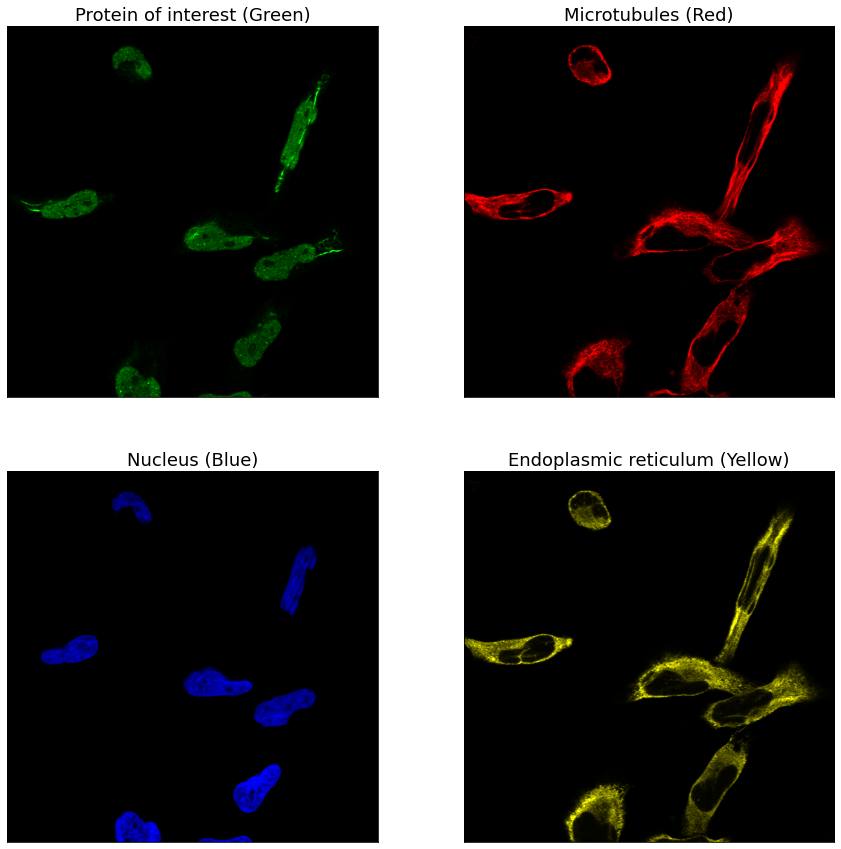

In [8]:
#create custom color maps
cdict1 = {'red':   ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'green': ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}

cdict2 = {'red':   ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'green': ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}

cdict3 = {'red':   ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'green': ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0))}

cdict4 = {'red': ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'green': ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}


newcmap = matplotlib.colors.LinearSegmentedColormap('greens', cdict1)
plt.register_cmap('greens', newcmap)

newcmap = matplotlib.colors.LinearSegmentedColormap('greens', cdict2)
plt.register_cmap('reds', newcmap)

newcmap = matplotlib.colors.LinearSegmentedColormap('greens', cdict3)
plt.register_cmap('blues', newcmap)

newcmap = matplotlib.colors.LinearSegmentedColormap('greens', cdict4)
plt.register_cmap('yellows', newcmap)

green = cv2.imread('../input/hpa-single-cell-image-classification/train/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_green.png', 0)
red = cv2.imread('../input/hpa-single-cell-image-classification/train/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_red.png', 0)
blue = cv2.imread('../input/hpa-single-cell-image-classification/train/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_blue.png', 0)
yellow = cv2.imread('../input/hpa-single-cell-image-classification/train/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png', 0)

#display each channel separately
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(15, 15))
ax[0, 0].imshow(green, cmap="greens")
ax[0, 0].set_title("Protein of interest (Green)", fontsize=18)
ax[0, 1].imshow(red, cmap="reds")
ax[0, 1].set_title("Microtubules (Red)", fontsize=18)
ax[1, 0].imshow(blue, cmap="blues")
ax[1, 0].set_title("Nucleus (Blue)", fontsize=18)
ax[1, 1].imshow(yellow, cmap="yellows")
ax[1, 1].set_title("Endoplasmic reticulum (Yellow)", fontsize=18)
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].tick_params(left=False, bottom=False)
plt.show()

Let's visualize the RGB image for image id 5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0 with it's labels

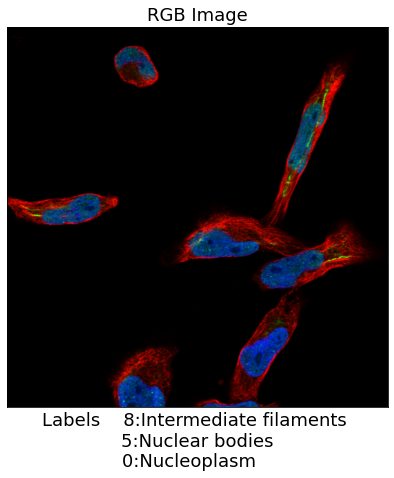

In [9]:
# mearging RGB channels to produce RGB image
plt.figure(figsize=(7,7))
green = cv2.imread('../input/hpa-single-cell-image-classification/train/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_green.png', cv2.IMREAD_UNCHANGED)
red = cv2.imread('../input/hpa-single-cell-image-classification/train/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_red.png', cv2.IMREAD_UNCHANGED)
blue = cv2.imread('../input/hpa-single-cell-image-classification/train/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_blue.png', cv2.IMREAD_UNCHANGED)
img = cv2.merge((red, green, blue))
cv2.imwrite('first_image.tif', img)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title("RGB Image", fontsize=18)
plt.xlabel('Labels    8:Intermediate filaments \n5:Nuclear bodies\n0:Nucleoplasm   ', fontsize=18)
plt.tick_params(left=False, bottom=False)
plt.show()

Let's visualize each label individually. We know what each lalel represents here but if we visualize them, we will able to undestand them more clearly.

### Train Data Preprocessing

&emsp;&emsp;&emsp; Since each images have many cells with different labels so to visualize each label individually we will need to crop each cell with it's corresponding label from the given images and them visualize them.

These are the steps to crop individual cells from images:  
1. Image segmentation (the segmentation process will segment individual cells in the given images and then label it with corresponding classes).
2. Cropping process (the cropping process will crop individual cells from all images after segmentation).

**Processing train.csv data to perform image segmentation**

In [10]:
class_labels = [str(i) for i in range(19)] # list of class labels [0-18]

train_label = train_df.Label # labels in training data

# one-hot encoding of class labels in training data
for x in class_labels: 
    train_df[x] = train_df['Label'].apply(lambda r: int(x in r.split('|')))
    
train_df.head()

,ID,Label,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Now there are 19 more binary columns. To understand them lets take image of first record, it has labels 8,5,0 so for this image the values for columns '8', '5', '0' are 1 and other (0-19 except 0,5,8) are 0. Same with other images also.    
     
1 mean True.    
0 mean False.

**Checking class labels imbalancies**

In [11]:
len(train_df.Label.unique())

432

There are total 432 unique values

In [12]:
max_label_counts = 0

for i in train_df.Label.unique():
    if(max_label_counts <= len(i.split('|'))):
        max_label_counts = len(i.split('|'))
        
max_label_counts

5

The maximum number of labels for an Image in our training data are 5

In [13]:
min_label_counts = 1

for i in train_df.Label.unique():
    if(max_label_counts >= len(i.split('|'))):
        max_label_counts = len(i.split('|'))
        
min_label_counts

1

The minimum number of class labels for an Image in our training data is 1

**Class labels imbalancies Visualization**

In [14]:
# Adding string lables in training csv data for better visualization
Labels = {0:  "Nucleoplasm", 1:  "Nuclear membrane",  2:  "Nucleoli",  3:  "Nucleoli fibrillar center" ,  4:  "Nuclear speckles",
          5:  "Nuclear bodies", 6:  "Endoplasmic reticulum",  7:  "Golgi apparatus", 8:  "Intermediate filaments",
          9:  "Actin filaments", 10: "Microtubules", 11:  "Mitotic spindle", 12:  "Centrosome",  13:  "Plasma membrane",
          14:  "Mitochondria",   15:  "Aggresome", 16:  "Cytosol",  17:  "Vesicles and punctate cytosolic patterns",   
          18:  "Negative"}

# Map the Individual labels to String_label
train_df["string_label"] = train_df.Label.apply(lambda x: "|".join([Labels[int(i)] for i in x.split("|")]))
train_df.head()

,ID,Label,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,string_label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Intermediate filaments|Nuclear bodies|Nucleoplasm
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Mitochondria|Nucleoplasm
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Endoplasmic reticulum|Nuclear membrane
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,Cytosol|Microtubules
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Mitochondria|Nucleoplasm


In [15]:
label_counts = Counter([c for sublist in train_df.string_label.str.split("|").to_list() for c in sublist])
fig = px.bar(x=label_counts.keys(), y=label_counts.values(), opacity=0.85, 
             color=label_counts.keys(),
             labels={
                 "y":"Number of Occurences Within The Dataset", 
                 "x":"Label Name", 
                 "color":"Label Name"
             },
             title="Number of Occurences For Each Label Within The Dataset")
fig.update_layout(legend_title=None,
                  xaxis_title="Label Names",
                  yaxis_title="Number of Occurences Within The Dataset")
fig.update_xaxes(categoryorder="total descending")
fig.show()

From the above graph

1. We can see that the training data highly imbalanced. 

2. We can see that most common protein structures belong to coarse grained cellular components Nucleoplasm.  
   
3. In contrast small or thin components like the mitotic spindle, microtubles, and vesicles are very seldom in our train data. In addition, rare organelles like Aggresome's and Negative also have very little representation in the dataset. For these classes the prediction will be very difficult as we have only a few examples that may not cover all variation normally present within these biological structures will be captured. So, we will struggle to make accurate predictions on the minor classes.

Let's compare the number of occurance of each label indiviaully with total occurance

In [16]:
unique_counts = {}
for label in class_labels:
    unique_counts[label] = len(train_df[train_df.Label == label])

full_counts = {}
for label in class_labels:
    count = 0
    for row_label in train_df['Label']:
        if label in row_label.split('|'): count += 1
    full_counts[label] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'Total Count', 'Individual Count'])
counts.label = [int(i) for i in counts.label]
counts = counts.sort_values(by='label')
counts.set_index('label').T

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Total Count,8797,1095,2451,1262,1425,1792,775,1846,964,998,818,78,1734,3111,2013,252,5685,593,34
Individual Count,1551,221,515,549,788,636,476,719,529,294,404,1,561,818,1054,82,906,274,34


#### Sampling

To deal with class imbalancies, we will perform downsampling here..   
    
Steps:   
1. We will first choose 500 records randomly which have single label for each label.
2. There are some class labels which don't have 500 records so for those labels we will select remaining records from the records which have more than one label.
3. If still some lable don't have 500 records we will leave them as it is.

In [17]:
train_dfs_0 = train_df[train_df['Label'] == '0'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_1u = train_df[train_df['Label'] == '1'].sample(n=221, random_state=42).reset_index(drop=True)
train_dfs_1 = train_df[train_df['1'] == 1].sample(n=500-221, random_state=42).reset_index(drop=True)
train_dfs_2 = train_df[train_df['Label'] == '2'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_3 = train_df[train_df['Label'] == '3'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_4 = train_df[train_df['Label'] == '4'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_5 = train_df[train_df['Label'] == '5'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_6u = train_df[train_df['Label'] == '6'].sample(n=476, random_state=42).reset_index(drop=True)
train_dfs_6 = train_df[train_df['6'] == 1].sample(n=500-476, random_state=42).reset_index(drop=True)
train_dfs_7 = train_df[train_df['Label'] == '7'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_8 = train_df[train_df['Label'] == '8'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_9u = train_df[train_df['Label'] == '9'].sample(n=294, random_state=42).reset_index(drop=True)
train_dfs_9 = train_df[train_df['9'] == 1].sample(n=500-294, random_state=42).reset_index(drop=True)
train_dfs_10u = train_df[train_df['Label'] == '10'].sample(n=404, random_state=42).reset_index(drop=True)
train_dfs_10 = train_df[train_df['10'] == 1].sample(n=500-404, random_state=42).reset_index(drop=True)
train_dfs_11u = train_df[train_df['Label'] == '11'].sample(n=1, random_state=42).reset_index(drop=True)
train_dfs_11 = train_df[train_df['11'] == 1].reset_index(drop=True)
train_dfs_12 = train_df[train_df['Label'] == '12'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_13 = train_df[train_df['Label'] == '13'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_14 = train_df[train_df['Label'] == '14'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_15u = train_df[train_df['Label'] == '15'].sample(n=82, random_state=42).reset_index(drop=True)
train_dfs_15 = train_df[train_df['15'] == 1].reset_index(drop=True)
train_dfs_16 = train_df[train_df['Label'] == '16'].sample(n=500, random_state=42).reset_index(drop=True)
train_dfs_17u = train_df[train_df['Label'] == '17'].sample(n=274, random_state=42).reset_index(drop=True)
train_dfs_17 = train_df[train_df['17'] == 1].sample(n=500-274, random_state=42).reset_index(drop=True)
train_dfs_18 = train_df[train_df['18'] == 1].reset_index(drop=True)
train_dfs_ = [train_dfs_0, train_dfs_1u, train_dfs_1, train_dfs_2, train_dfs_3, train_dfs_4, train_dfs_5, train_dfs_6u,
              train_dfs_6, train_dfs_7, train_dfs_8, train_dfs_9u, train_dfs_9, train_dfs_10u, train_dfs_10, train_dfs_11u, 
              train_dfs_11, train_dfs_12, train_dfs_13, train_dfs_14, train_dfs_15u, train_dfs_15, train_dfs_16,
              train_dfs_17u, train_dfs_17, train_dfs_18]

In [18]:
train_dfs = pd.concat(train_dfs_, ignore_index=True)
train_dfs.drop_duplicates(inplace=True, ignore_index=True)
len(train_dfs)

8081

After sampling there are total 8081 records but we have now balanced dataset which is good for training our model.

In [19]:
train_dfs.head()

,ID,Label,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,string_label
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nucleoplasm
1,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nucleoplasm
2,2533bcc2-bba5-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nucleoplasm
3,280f88c2-bba5-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nucleoplasm
4,13669cc6-bbaa-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nucleoplasm


Let's compare the number of occurance of each label indiviaully with total occurance in our sampled dataset

In [20]:
unique_counts = {}
for label in class_labels:
    unique_counts[label] = len(train_dfs[train_dfs.Label == label])

full_counts = {}
for label in class_labels:
    count = 0
    for row_label in train_dfs['Label']:
        if label in row_label.split('|'): count += 1
    full_counts[label] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'Total Count', 'Individual Count'])
counts.label = [int(i) for i in counts.label]
counts = counts.sort_values(by='label')
counts.set_index('label').T

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Total Count,891,450,571,520,528,548,494,519,521,452,472,78,546,613,520,252,727,397,34
Individual Count,500,221,500,500,500,500,476,500,500,294,404,1,500,500,500,82,500,274,34


Now we have balaced data set so the next is we have to perform segmentation and masking to crop individual cells from given images to visualize it and for training purpose also.

#### Image Segmantation

For segmentation we will use a pretrained model which is specific to cell segementation, read more about it from https://github.com/CellProfiling/HPA-Cell-Segmentation/

please compile abn


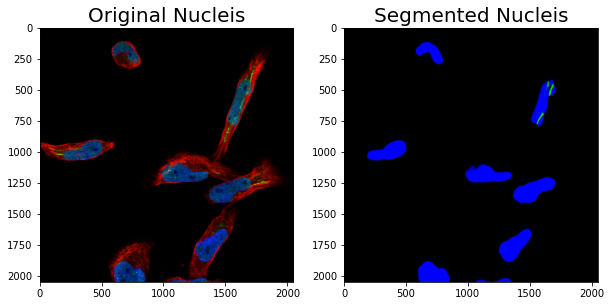

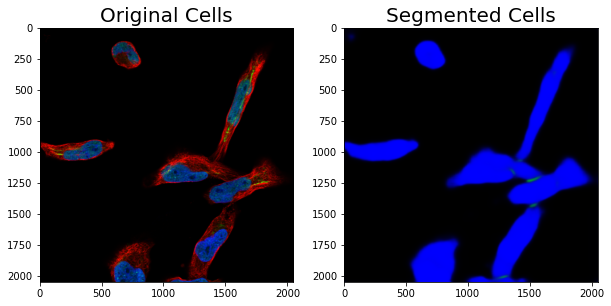

In [21]:
import warnings
warnings.filterwarnings('ignore')

import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

from sklearn.preprocessing import MultiLabelBinarizer
from array import array

NUC_MODEL = "../input/processed-hpa-data/nuclei-model.pth"
CELL_MODEL = "../input/processed-hpa-data/cell-model.pth"

segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    padding=False,
    multi_channel_model=True,
)

nuc_segmentations = segmentator.pred_nuclei([img])

f, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[0].set_title('Original Nucleis', size=20)
ax[1].imshow(nuc_segmentations[0])
ax[1].set_title('Segmented Nucleis', size=20)
plt.show()

# Cell segmentation
inter_step = [[i] for i in [red, green, blue]]
cell_segmentations = segmentator.pred_cells(inter_step)

f, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(cv2.merge((red, green, blue)))
ax[0].set_title('Original Cells', size=20)
ax[1].imshow(cell_segmentations[0])
ax[1].set_title('Segmented Cells', size=20)
plt.show()

Let's apply masking on above two segmented images so that we can visualize each cell individually

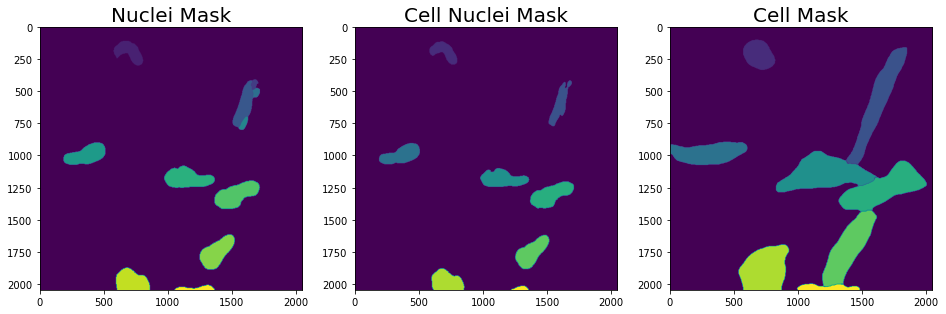

In [22]:
nuclei_mask = label_nuclei(nuc_segmentations[0])
# Cell masks
cell_nuclei_mask, cell_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])
# Plotting
f, ax = plt.subplots(1, 3, figsize=(16,16))
ax[0].imshow(nuclei_mask)
ax[0].set_title('Nuclei Mask', size=20)
ax[1].imshow(cell_nuclei_mask)
ax[1].set_title('Cell Nuclei Mask', size=20)
ax[2].imshow(cell_mask)
ax[2].set_title('Cell Mask', size=20)
plt.show()

Visualizing each cell individually.

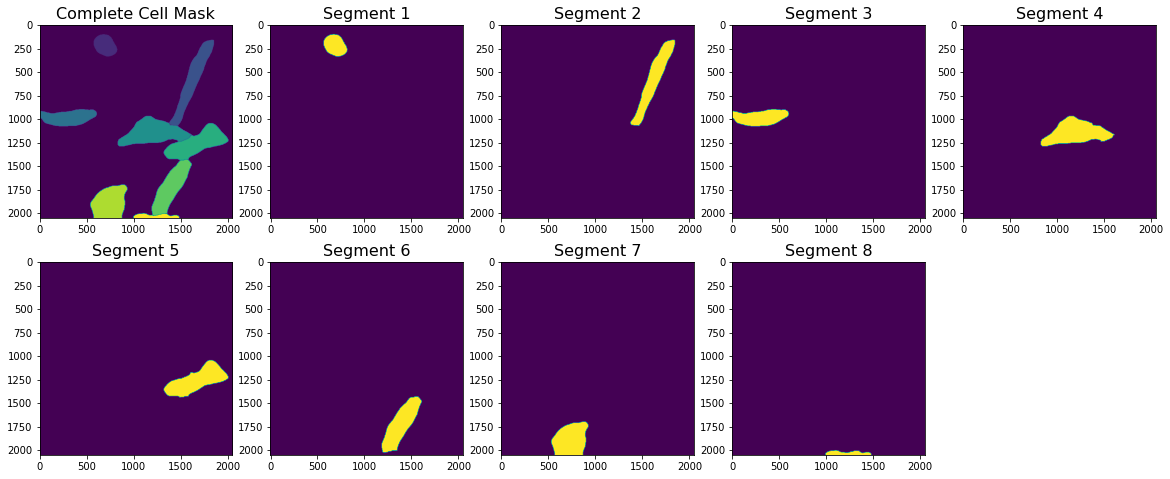

In [23]:
# Unique vector of cell_mask numbers
numbers = set(np.ravel(cell_mask))
numbers.remove(0)

fig = plt.figure(figsize=(20,len(numbers)))
index = 1

ax = fig.add_subplot(len(numbers)//5+1, 5, index)
ax.set_title("Complete Cell Mask", size=16)
plt.imshow(cell_mask)

index += 1
for number in numbers:
    isolated_cell = np.where(cell_mask==number, cell_mask, 0)
    ax = fig.add_subplot(len(numbers)//5+1, 5, index)
    ax.set_title(f"Segment {number}", size=16)
    plt.imshow(isolated_cell)
    index += 1

Let's segment all training images and crop invidual cell from all of them with their corresponding labels and create a new image dataset to train our model and visualizing each label individually as well.

In [24]:
# function to crop segmentaed cells from given images

def get_cropped_cell(img, msk):
    bmask = msk.astype(int)[...,None]
    masked_img = img * bmask
    true_points = np.argwhere(bmask)
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)
    cropped_arr = masked_img[top_left[0]:bottom_right[0]+1,top_left[1]:bottom_right[1]+1]
    return cropped_arr

In [25]:
# return height and widht of given images

def get_stats(cropped_cell):
    x = (cropped_cell/255.0).reshape(-1,3).mean(0)
    x2 = ((cropped_cell/255.0)**2).reshape(-1,3).mean(0)
    return x, x2

In [26]:
ROOT = '../input/hpa-single-cell-image-classification'
def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
    return img

The below code cell will take around 8 hours to complete. I have already run it and saved the output. SO I will directly use the save data.

In [27]:
"""
x_tot,x2_tot = [],[]
lbls = []
num_files = len(train_dfs)
all_cells = []
cell_mask_dir = '../input/hpa-mask/hpa_cell_mask'
train_or_test = 'train'

with zipfile.ZipFile('cells.zip', 'w') as img_out:

    for idx in tqdm(1606, 2000):
        image_id = train_dfs.iloc[idx].ID
        labels = train_dfs.iloc[idx].Label
        cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
        red = read_img(image_id, "red", train_or_test, None)
        green = read_img(image_id, "green", train_or_test, None)
        blue = read_img(image_id, "blue", train_or_test, None)
        #yellow = read_img(image_id, "yellow", train_or_test, image_size)
        stacked_image = np.transpose(np.array([blue, green, red]), (1,2,0))

        for cell in range(1, np.max(cell_mask) + 1):
            bmask = cell_mask == cell
            cropped_cell = get_cropped_cell(stacked_image, bmask)
            fname = f'{image_id}_{cell}.jpg'
            im = cv2.imencode('.jpg', cropped_cell)[1]
            img_out.writestr(fname, im)
            x, x2 = get_stats(cropped_cell)
            x_tot.append(x)
            x2_tot.append(x2)
            all_cells.append({
                'image_id': image_id, c
                'r_mean': x[0],
                'g_mean': x[1],
                'b_mean': x[2],
                'cell_id': cell,
                'image_labels': labels,
                'size1': cropped_cell.shape[0],
                'size2': cropped_cell.shape[1],
            })

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
cell_train_df = pd.DataFrame(all_cells)
cell_train_df.to_csv('cell_train_df.csv', index=False)
print('mean:',img_avr, ', std:', img_std)
"""
""

''

In [28]:
# loading processed train csv data
train_df = pd.read_csv('../input/processed-hpa-data/cell_train_df.csv')
train_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168


Since now we have individual images for each cell so lets visualize images for each label

In [29]:
# Choosing one-one image id belonging to each label

image_label_0 = train_df['image_id'][train_df['image_labels']=='0'].iloc[0]
image_label_1 = train_df['image_id'][train_df['image_labels']=='1'].iloc[0]
image_label_2 = train_df['image_id'][train_df['image_labels']=='2'].iloc[0]
image_label_3 = train_df['image_id'][train_df['image_labels']=='3'].iloc[0]
image_label_4 = train_df['image_id'][train_df['image_labels']=='4'].iloc[0]
image_label_5 = train_df['image_id'][train_df['image_labels']=='5'].iloc[0]
image_label_6 = train_df['image_id'][train_df['image_labels']=='6'].iloc[0]
image_label_7 = train_df['image_id'][train_df['image_labels']=='7'].iloc[0]
image_label_8 = train_df['image_id'][train_df['image_labels']=='8'].iloc[0]
image_label_9 = train_df['image_id'][train_df['image_labels']=='9'].iloc[0]
image_label_10 = train_df['image_id'][train_df['image_labels']=='10'].iloc[0]
image_label_11 = train_df['image_id'][train_df['image_labels']=='11'].iloc[0]
image_label_12 = train_df['image_id'][train_df['image_labels']=='12'].iloc[0]
image_label_13 = train_df['image_id'][train_df['image_labels']=='13'].iloc[0]
image_label_14 = train_df['image_id'][train_df['image_labels']=='14'].iloc[0]
image_label_15 = train_df['image_id'][train_df['image_labels']=='15'].iloc[0]
image_label_16 = train_df['image_id'][train_df['image_labels']=='16'].iloc[0]
image_label_17 = train_df['image_id'][train_df['image_labels']=='17'].iloc[0]
image_label_18 = train_df['image_id'][train_df['image_labels']=='18'].iloc[0]

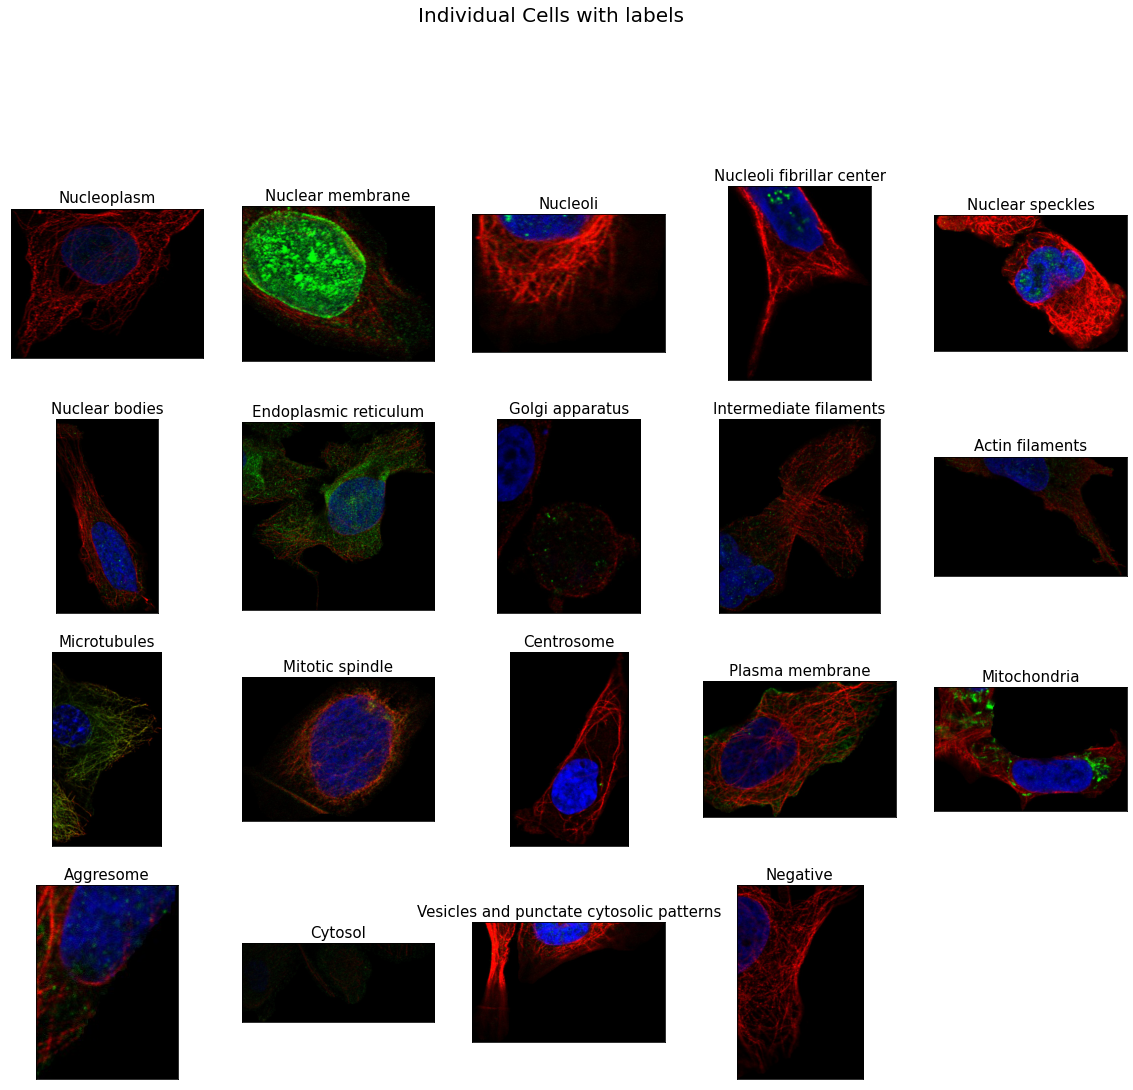

In [30]:
import matplotlib.image as mpimg
image_ids = [image_label_0, image_label_1 ,image_label_2, image_label_3,image_label_4 ,image_label_5,image_label_6,
             image_label_7, image_label_8, image_label_9, image_label_10, image_label_11, image_label_12,
             image_label_13, image_label_14, image_label_15, image_label_16, image_label_17, image_label_18]

plt.figure(figsize=(20,25))
for i, label in Labels.items():
    plt.subplot(6,5,int(i)+1)
    img = mpimg.imread('../input/processed-hpa-data/cells/cells/'+image_ids[int(i)]+'_1.jpg')
    imgplot = plt.imshow(img)
    plt.title(label, fontsize=15)
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Individual Cells with labels',fontsize=20)
plt.show()

### Test Data

&emsp;&emsp;&emsp; In test data there only images for which the labels will predict.

### Model Creation and Training

We will use fastai tool to create our model. We need images of individual cells as an input to the classification model. Due to system limitation we will not use all images for model training instead we have created a sample balanced dataset to train the model. We use RGB channels only, which has proven to work well in the previous HPA challenge. We saved the extracted cells as RGB jpg images already so that I can feed them easily into my classifier.
    
We will first train three models using three different pretrained models resnet, densenet and unet and after training we will compare which one will be best.
   
1. **Resnet**: A residual neural network (ResNet) is an artificial neural network (ANN) of a kind that builds on constructs known from pyramidal cells in the cerebral cortex. Residual neural networks do this by utilizing skip connections, or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between.An additional weight matrix may be used to learn the skip weights; these models are known as HighwayNets.   

2. **EfficientNet**: EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients.

3. **Densenet**: DenseNet is one of the new discoveries in neural networks for visual object recognition. DenseNet is quite similar to ResNet with some fundamental differences. ResNet uses an additive method (+) that merges the previous layer (identity) with the future layer, whereas DenseNet concatenates (.) the output of the previous layer with the future layer. 

In [31]:
labels = [str(i) for i in range(19)]
for x in labels: 
    train_df[x] = train_df['image_labels'].apply(lambda r: int(x in r.split('|')))
train_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2,0,1,...,9,10,11,12,13,14,15,16,17,18
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,1,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
# test data for checking the performace of our model after trainining

test_performance_df_0 = train_df[train_df['image_labels'] == '0'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_1 = train_df[train_df['image_labels'] == '1'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_2 = train_df[train_df['image_labels'] == '2'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_3 = train_df[train_df['image_labels'] == '3'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_4 = train_df[train_df['image_labels'] == '4'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_5 = train_df[train_df['image_labels'] == '5'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_6 = train_df[train_df['image_labels'] == '6'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_7 = train_df[train_df['image_labels'] == '7'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_8 = train_df[train_df['image_labels'] == '8'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_9 = train_df[train_df['image_labels'] == '9'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_10 = train_df[train_df['image_labels'] == '10'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_11 = train_df[train_df['image_labels'] == '10|11'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_11['image_labels'] = ['11']*25
test_performance_df_12 = train_df[train_df['image_labels'] == '12'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_13 = train_df[train_df['image_labels'] == '13'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_14 = train_df[train_df['image_labels'] == '14'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_15 = train_df[train_df['image_labels'] == '15'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_16 = train_df[train_df['image_labels'] == '16'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_17 = train_df[train_df['image_labels'] == '17'].sample(n=25, random_state=42).reset_index(drop=True)
test_performance_df_18 = train_df[train_df['image_labels'] == '18'].sample(n=25, random_state=42).reset_index(drop=True)

test_performance_df_ = [test_performance_df_0, test_performance_df_1, test_performance_df_2, test_performance_df_3, test_performance_df_4, test_performance_df_5,
                      test_performance_df_6, test_performance_df_7, test_performance_df_8, test_performance_df_9, test_performance_df_10, test_performance_df_11,
                      test_performance_df_12, test_performance_df_13, test_performance_df_14, test_performance_df_15, test_performance_df_16, test_performance_df_17,
                      test_performance_df_18]

test_performance_df = pd.concat(test_performance_df_, ignore_index=True)
test_performance_df.drop_duplicates(inplace=True, ignore_index=True)

test_performance_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2,0,1,...,9,10,11,12,13,14,15,16,17,18
0,96971788-bbc3-11e8-b2bc-ac1f6b6435d0,0.058740,0.097258,0.048798,17,0,314,241,1,0,...,0,0,0,0,0,0,0,0,0,0
1,57c12c30-bba3-11e8-b2b9-ac1f6b6435d0,0.049480,0.023562,0.097921,17,0,467,531,1,0,...,0,0,0,0,0,0,0,0,0,0
2,6f062840-bba9-11e8-b2ba-ac1f6b6435d0,0.065905,0.014036,0.038552,18,0,476,456,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9a92003a-bbc0-11e8-b2bb-ac1f6b6435d0,0.006112,0.013585,0.004849,3,0,249,352,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4b153af0-bbc4-11e8-b2bc-ac1f6b6435d0,0.004491,0.052781,0.068927,20,0,356,474,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# 20% sampled dataset 
train_dfs = train_df.sample(frac=0.20, random_state=42)
train_dfs = train_dfs.reset_index(drop=True)
len(train_dfs)

35599

Let's compare the number of occurance of each label indiviaully with total occurance in our sampled dataset

In [34]:
unique_counts = {}
for lbl in labels:
    unique_counts[lbl] = len(train_dfs[train_dfs.image_labels == lbl])

full_counts = {}
for lbl in labels:
    count = 0
    for row_label in train_dfs['image_labels']:
        if lbl in row_label.split('|'): count += 1
    full_counts[lbl] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'Total Count', 'Individual Count'])
counts.set_index('label').T

label,16,0,13,2,5,12,7,14,3,4,1,8,6,10,17,9,15,11,18
Total Count,3568,3334,2948,2947,2799,2799,2738,2725,2604,2402,2239,2171,2154,2038,2019,1805,1270,455,196
Individual Count,1830,658,2127,2397,2463,2515,2547,2594,2378,2214,919,2061,1377,1253,897,823,473,0,196


Class label 11 has 0 individual counts, this may create zero division error. To handle this we will add 10 records for label 11 from records label '10|11'.

In [35]:
df_11 = train_df[train_df.image_labels.str.contains('11')][0:10]
df_11['image_labels'] = ['11']*10
train_dfs = pd.concat((train_dfs, df_11))

unique_counts = {}
for lbl in labels:
    unique_counts[lbl] = len(train_dfs[train_dfs.image_labels == lbl])

full_counts = {}
for lbl in labels:
    count = 0
    for row_label in train_dfs['image_labels']:
        if lbl in row_label.split('|'): count += 1
    full_counts[lbl] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'Total Count', 'Individual Count'])
counts.set_index('label').T

label,16,0,13,2,5,12,7,14,3,4,1,8,6,10,17,9,15,11,18
Total Count,3568,3334,2948,2947,2799,2799,2738,2725,2604,2402,2239,2171,2154,2038,2019,1805,1270,465,196
Individual Count,1830,658,2127,2397,2463,2515,2547,2594,2378,2214,919,2061,1377,1253,897,823,473,10,196


Now Label 11 has 10 individual counts.

Spliting the sampled training data into training data and validation data using stratify method to balance the class labels on both train and validation data.

In [36]:
nfold = 5

y = train_dfs[labels].values
X = train_dfs[['image_id', 'cell_id']].values

train_dfs['fold'] = np.nan

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, shuffle=True, random_state=None)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_dfs.iloc[test_index, -1] = i
    
train_dfs['fold'] = train_dfs['fold'].astype('int')

In [37]:
train_dfs['is_valid'] = False
train_dfs['is_valid'][train_dfs['fold'] == 0] = True

In [38]:
train_dfs.is_valid.value_counts()

False    28494
True      7115
Name: is_valid, dtype: int64

Now there are 29125 records in Train data and 7284 records in validation data.

In [39]:
# defining function to return image for given image id
def get_x(r): 
    return '../input/processed-hpa-data/cells/cells/'+(r['image_id']+'_'+str(r['cell_id'])+'.jpg')

# defining function to return label for 
def get_y(r): 
    return r['image_labels'].split('|')

In [40]:
# sample_stats = (image_array_mean, image_array_std) # one image have 3 channels # mean and std of all cell images.
sample_stats = ([0.07290461, 0.04505656, 0.07713918] , [0.1727259 , 0.10327134, 0.14257778])
item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(flip_vert=True, size=128, max_warp=0), Normalize.from_stats(*sample_stats)]
bs=128

In [41]:
# code to create batch dataset
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab=labels)),
                splitter=ColSplitter(col='is_valid'),
                get_x=get_x,
                get_y=get_y,
                item_tfms=item_tfms,
                batch_tfms=batch_tfms,
                )
dls = dblock.dataloaders(train_dfs, bs=bs)

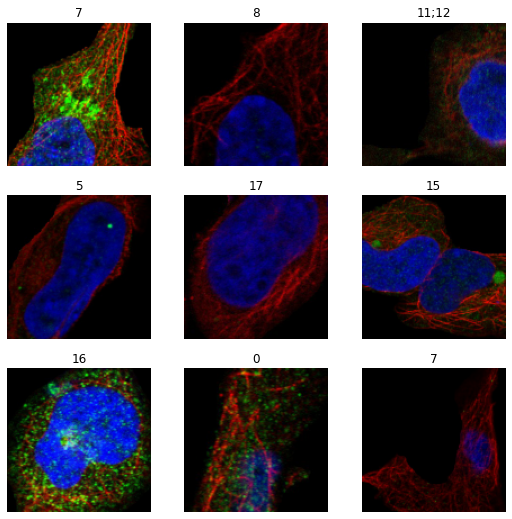

In [42]:
dls.show_batch(nrows=3, ncols=3)

**Training with Resnet**

In [43]:
# copying pretrained models 
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')

!cp ../input/models/resnet50-19c8e357.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/models/densenet121-a639ec97.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/models/adv-efficientnet-b7-4652b6dd.pth /root/.cache/torch/hub/checkpoints/

In [44]:
#creating our cnn model

res_learn = cnn_learner(dls, resnet50, metrics=[accuracy_multi, PrecisionMulti()]).to_fp16()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.02754228748381138)

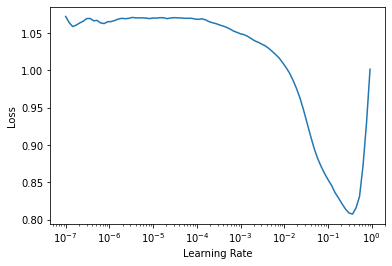

In [45]:
torch.cuda.empty_cache()
res_learn.lr_find()

The suggested value of learning parameter is around 0.03

In [46]:
lr=3e-2 # learning parameter
torch.cuda.empty_cache() # empty GPU cache memory
res_learn.fine_tune(5,base_lr=lr) # starting training with 5 epochs

epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.222123,0.181366,0.941096,0.530855,05:00


epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.172504,0.172025,0.942242,0.644974,04:30
1,0.165358,0.169987,0.945793,0.690806,04:33
2,0.154425,0.147714,0.950483,0.667084,04:32
3,0.141093,0.136181,0.953996,0.728869,04:32
4,0.132128,0.132426,0.955054,0.788000,04:32


After epoch 7 the difference between train and valid loss started increasing but both are decreasing so to prevent our model from being overfit 10 epochs are enough and if we want to increase the accuracy further so we should increase the fraction of training data. Currently we have trained our on 20% of total training data due to system limitations.

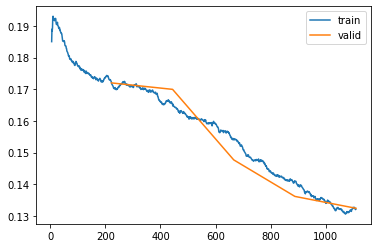

In [47]:
res_learn.recorder.plot_loss() # plotting train and validation loss

In [48]:
res_learn.save('hpa_resnet50_model') # saving our model

Path('models/hpa_resnet50_model.pth')

#### Training with Efficient net

In [49]:
# locating and downloading the pretrained Efficient net model
# We will use transfer learning method with Efficientnet-B7 to train our learner


package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)

%cd /kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master
from efficientnet_pytorch import EfficientNet
%cd -

def get_learner(lr=1e-3):
    # Optimization funciton and parameters
    opt_func = partial(Adam, lr=lr, wd=0.01, eps=1e-8)    
    model = EfficientNet.from_pretrained("efficientnet-b7", advprop=True)
    # Set output layer
    model._fc = nn.Linear(2560, dls.c)
    # Group model, dataloader and metrics
    learn = Learner(
        dls, model, opt_func=opt_func,
        metrics=[accuracy_multi, PrecisionMulti()]
        ).to_fp16()
    return learn

/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master
/kaggle/working


In [50]:
# Initialize lerner
effi_learn=get_learner()

Loaded pretrained weights for efficientnet-b7


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0020892962347716093)

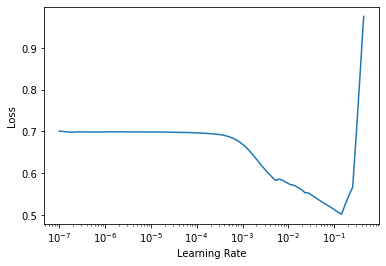

In [51]:
# Finding best value for learning parameter


torch.cuda.empty_cache()
effi_learn.lr_find()


In [52]:
# Training our model 

lr = 1e-3
torch.cuda.empty_cache()
effi_learn.fine_tune(5,base_lr=lr)


epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.196472,0.218708,0.937027,0.491354,07:24


epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.147868,0.162159,0.946577,0.609817,07:25
1,0.143006,0.142990,0.952080,0.715678,07:25
2,0.129618,0.131315,0.954773,0.736462,07:26
3,0.108958,0.123560,0.957451,0.731708,07:24
4,0.095444,0.121629,0.958235,0.741101,07:26


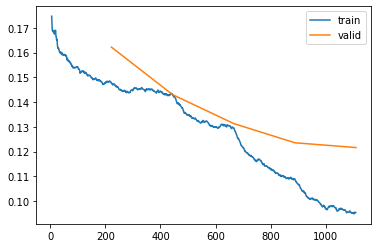

In [53]:
effi_learn.recorder.plot_loss()

In [54]:
effi_learn.save('hpa_effi-b7_model') # saving our model

Path('models/hpa_effi-b7_model.pth')

#### Traininig with densenet

In [55]:
dens_learn = cnn_learner(dls, models.densenet121, metrics=[accuracy_multi, PrecisionMulti()]).to_fp16()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.033113110810518265)

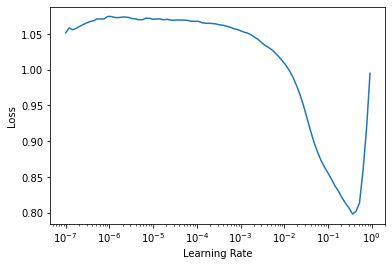

In [56]:

torch.cuda.empty_cache() # empty GPU cache memory
dens_learn.lr_find() # finding best value for learning parameter to train our cnn model


In [57]:

lr=3e-2 # learning parameter
torch.cuda.empty_cache() # empty GPU cache memory
dens_learn.fine_tune(5,base_lr=lr) # starting training with 5 epochs


epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.212026,0.171983,0.943781,0.616051,04:46


epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.167865,0.162699,0.945970,0.678449,04:54
1,0.161011,0.155149,0.947590,0.714275,04:54
2,0.148737,0.144516,0.951437,0.781730,04:53
3,0.135570,0.133148,0.954921,0.784708,04:51
4,0.127250,0.130601,0.955653,0.770908,04:51


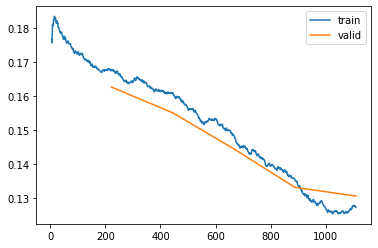

In [58]:
dens_learn.recorder.plot_loss()

In [59]:
dens_learn.save('hpa_densenet121_model') # saving our model

Path('models/hpa_densenet121_model.pth')

### Models Comparison

We have trained 3 models based on resnet, efficientnet and densenet to find out which one will be better. We have trained each model for 5 epochs-  
   
After 5 epochs the losses for    
Resnet are :- Train Loss = 0.132128 and Validation Loss = 0.132426  
Efficient net are :- Train Loss = 0.095444 and Validation Loss = 0.121629     
Densenet are :- Train Loss = 0.127250 and Validation Loss = 0.130601     
     
The difference between Train Loss and Validation Loss is less in Resnet based model so it means it's a balanced model not an overfitted or underfitted model. So we will use Resnet based model to preform prediction on test images.

##### Let's train resnet model for 10 epochs to get more better results. Since we training our model on 20% of the data due to system limitations so it's performance will be less. To increase the performance of the model train it on 100% data.

In [60]:
res_learn = cnn_learner(dls, resnet50, metrics=[accuracy_multi, PrecisionMulti(), RocAucMulti()]).to_fp16()
lr=3e-2 # learning parameter
torch.cuda.empty_cache() # empty GPU cache memory
res_learn.fine_tune(10,base_lr=lr) # starting training with 5 epochs

epoch,train_loss,valid_loss,accuracy_multi,precision_score,roc_auc_score,time
0,0.219586,0.180099,0.942220,0.578400,0.822372,04:23


epoch,train_loss,valid_loss,accuracy_multi,precision_score,roc_auc_score,time
0,0.166788,0.159753,0.947576,0.658658,0.864163,04:34
1,0.164611,0.165594,0.945512,0.695798,0.862216,04:36
2,0.162312,0.161819,0.945489,0.662392,0.867902,04:35
3,0.155271,0.153656,0.949403,0.705295,0.884003,04:36
4,0.147031,0.144146,0.952044,0.711436,0.894274,04:37
5,0.141976,0.140174,0.953035,0.727742,0.899176,04:34
6,0.133403,0.136901,0.953982,0.716938,0.904779,04:35
7,0.123272,0.131588,0.955180,0.751574,0.913668,04:34
8,0.117595,0.128033,0.956534,0.756657,0.918010,04:33
9,0.112928,0.127936,0.956452,0.744535,0.918425,04:33


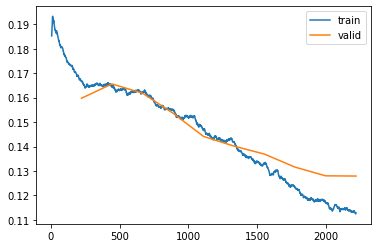

In [61]:
res_learn.recorder.plot_loss() # plotting train and validation loss

### Model Prediction on Test Data

In [62]:
# loading sample_submission.csv into a dataframe 
test_df = pd.read_csv('../input/hpa-single-cell-image-classification/sample_submission.csv')
test_df

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==
...,...,...,...,...
554,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,1728,1728,0 1 eNoLCAjJNgIABNkBkg==
555,feb955db-6c07-4717-a98b-92236c8e01d8,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
556,fefb9bb7-934a-40d1-8d2f-210265857388,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
557,ff069fa2-d948-408e-91b3-034cfea428d1,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


In sample submission we have Image files name for which we have to perform prediction. By looking at the sample submission, we realize that we need to predict a string for each test image which can be generate as below.   

1. Segment each single cell contained in the image.
2. Predict their class labels confidence.
3. Then generate a string by doing encoding of segmented cells.

The structure of the prediction string is as

ImageID,ImageWidth,ImageHeight,PredictionString

1. ImageAID,ImageAWidth,ImageAHeight,LabelA1 ConfidenceA1 EncodedMaskA1 LabelA2 ConfidenceA2 EncodedMaskA2 ...

2. ImageBID,ImageBWidth,ImageBHeight,LabelB1 ConfidenceB1 EncodedMaskB1 LabelB2 ConfidenceB2 EncodedMaskB2 …

Sample real values could be..

ID,ImageWidth,ImageHeight,PredictionString
1. 721568e01a744247,1118,1600,0 0.637833 eNqLi8xJM7BOTjS08DT2NfI38DfyM/Q3NMAJgJJ+RkBs7JecF5tnAADw+Q9I
2. 7b018c5e3a20daba,1600,1066,16 0.85117 eNqLiYrLN7DNCjDMMIj0N/Iz9DcwBEIDfyN/QyA2AAsBRfxMPcKTA1MMADVADIo=

Below is the code to encode the segmentation mask provided by the organiser..

Next two cells will create encoded string for each segmented cells in images and the whole process will take around 1 hours to complete for all images. I have already run it so I will use the saved data.

In [ ]:
"""
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray) -> t.Text:

  # check input mask --
  if mask.dtype != np.bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str.decode('ascii')
  
"""
''

Performing test image segmentation and generating encoding strings..

In [ ]:
"""
x_tot,x2_tot = [],[]
lbls = []
num_files = len(test_df)
all_cells = []
train_or_test = 'test'
cell_mask_dir = 'F:/HPA/work/cell_masks'

with zipfile.ZipFile('F:/HPA/test_cells.zip', 'w') as img_out:

    for idx in tqdm(range(num_files)):
        image_id = test_df.iloc[idx].ID
        cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
        red = read_img(image_id, "red", train_or_test, None)
        green = read_img(image_id, "green", train_or_test, None)
        blue = read_img(image_id, "blue", train_or_test, None)
        #yellow = read_img(image_id, "yellow", train_or_test, image_size)
        stacked_image = np.transpose(np.array([blue, green, red]), (1,2,0))

        for j in range(1, np.max(cell_mask) + 1):
            bmask = (cell_mask == j)
            enc = encode_binary_mask(bmask)
            cropped_cell = get_cropped_cell(stacked_image, bmask)
            fname = f'{image_id}_{j}.jpg'
            im = cv2.imencode('.jpg', cropped_cell)[1]
            img_out.writestr(fname, im)
            x, x2 = get_stats(cropped_cell)
            x_tot.append(x)
            x2_tot.append(x2)
            all_cells.append({
                'image_id': image_id,
                'fname': fname,
                'r_mean': x[0],
                'g_mean': x[1],
                'b_mean': x[2],
                'cell_id': j,
                'size1': cropped_cell.shape[0],
                'size2': cropped_cell.shape[1],
                'enc': enc,
            })

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
cell_test_df = pd.DataFrame(all_cells)
cell_test_df.to_csv('F:/HPA/cell_test_df.csv', index=False)
print('mean:',img_avr, ', std:', img_std)
"""
""

In [63]:
# loading saved data for encoded cell segment 
cell_test_df = pd.read_csv('../input/processed-hpa-data/cell_test_df.csv')
cell_test_df.head()

,image_id,fname,r_mean,g_mean,b_mean,cell_id,size1,size2,enc
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_1.jpg,0.042343,0.032151,0.073973,1,342,1050,eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJQ3KyD//9t1KPhu1M22Rp9Op0+n0+mM87cMoj1osoHmgDN8aeCormcu7nBXgQ+ehxXWFczA9bDBPaF6ihPHrWECyRR/hTV4ulyuSLqm0GFMxOpDvRP18Ep+tynLSBV1RzGc8BzGg16HSIq67ArBrfnL9Zp2i/y2fHCXkg/EEndH0wZn4nGL83Un/cxvL5z/znmGbR/547j9q357wNPbeTj+eVfOUeZqzsl659RF2iFSDuMhWAaL5B79fB9lpOKPFk7p41Zbv9liAz9nMf6tN/Duxvin3UCiNRH+8lIotTxC7kQpCC2NcO4sU6i0dYSek6TQanGEYyeTMn0domcnOTT6MsSpneaw16MQJ3aeg8t4iI0lcghZG2BhuQUsWB1gbs0KiJgIMLN4ASuWB5hYUQEFiwMMrayAkoUBBlZZwJb5AXJrV4BgXoC+1RRQsUmAnjUuoWEtR9dyS2hZw3FseSVMDcGxNnkJcyPnKMy4BG5sOBZmUsLCWHHMzE0JsRFxTM28hKURcNyY2xJWxpzj2qxKSIwpoYbQmGbHW6nX+hK5W6lX...
1,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_2.jpg,0.034332,0.027210,0.045968,2,762,680,eNrVUm1PwkAM/kvt3XgRjEajvO7uhGCEEHCgcSQi/v9vXtudbGwzQT+5JteXe67tnna7fE1wC6tPVA5tFGujrDLa+tOhjyixRFcI421kPMKBy6KmEbeG9F7H7QG91+YJd1YqRLEgLu8Ewb5HdGv8kCGFBXXkrdZQ9AGmHEFfVyIXfXQAmEW1aQ/yPqHgd59DOb2AHORK5nocQADn4siaOwZkTrL+hPGAEs6DXRL5Y+G7dCvvaIolHJ+W5xtrV5it0TJ3b0U01bg5Zn2csmxHzudZ2WisbaFeyN/rFPu5uSY2rOp1iBej+h2ZBxMJhGLGgB3yX+JVaqfPbrLAfQKPqT2s3cccpxuy92v3PsfZBp5Su127xMBiibsE3nx1ynp7xRrvu0ZL/Wo9bFXHA/vEzDn+t2TTpxuyLJ7lQ3GzQPLxFvl7xzuV9y0S3qpRo9TfsTNCjxt/+7/a/62R/5I/xHmPf+Br1KzOd7pPp/iwh6f7lsUnD/sZfgE+j18v
2,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_3.jpg,0.093926,0.033953,0.078939,3,398,470,eNoLCEgJMg4wDMg3NPQ39Df2NfaF0EZ+IBoBIXzc8oSgARxA2OiiuMWJBYT0kyuPLk4aH+F/6ojTS57a5tALwtIpqemTVvYDaQMDIwM/eJoCiQJJXO4EhqCBPyQ8/Yz8DbAlLScA3+jcjQ==
3,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_4.jpg,0.120287,0.085569,0.099383,4,372,344,eNptUstOAzEM/CUnXtoiAQcegnbzOMAFgdRFbIXEpf9/q+2pd0vYjZQde8aPxBmHz4EG2h9DLDGtHg5hLIJK198+muf+i7YKusQ11JD5vf5QjUXQ041KE+9WagsbLVRRu1re9sKI769qIHKt+hyhDnRzXvCZMy/zrU76W/R7Ha1N5B3Mnfii6RMsDgHqrbrDINWc7SnExJf6i0RzsaY42iNkXdChJbXswK3er3jiEedHEZXzgv7ni/P1GAq5U32O55FFjAeKIgPowXPBcDmjfoSdO/D2eOw17dTmhIGx+l0v/Qj7l3+5hv28Sfpf7+sdHB91JHO9fb/+xhOdSqvy
4,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_5.jpg,0.088759,0.076198,0.077768,5,544,244,eNp9UcuSmzAQ/CVGku1U8CGpxBs7EsMrPNdgMNYasIH/v0UD61RctbXo0D2tHqk1/Okvr5Dw9g4MmRL7Lzjjt8payE/bZQgO323nmu9sF1xTdy+ZOmvMRZFDK2uNmShz6GSlMSVtlIXGSNQ5eCrTGIq3HCaZagzElbREoy/aHEIVaPTEPYdC5Q0GK30ET2YN+qu3I/gybdAjLZZRg4O4HGGQZYXluj5BsKJkv74iM5ksyuWC9cEH7meLIXcI7Z1B80ihBNVYWd+XDe4smECHz5btewt3KAFgY5Xu4t0cFjSzc8nBcHHYL89nGp9ijxMM2rvlZOY+wtMN5LxYBb2y2F8TLDd5C/V+SDDbVC08ZeLvN3Yxng5BB6f1FGNNrFyPMZ4PIbEbsaSD85rjc6IHzsk/GJNJSjuFm0Q4yL4HX6QRjrIjZrSJmEeapwwbuWGhuvdw5VGEqZp60KRNciRfSL0TsYA6vJvp8CIMlH+DgZ/nv4rM4csMaYrmhf9mhv8v7ohZ3/5Y/RZUq6XLi8OI/QVl/s76


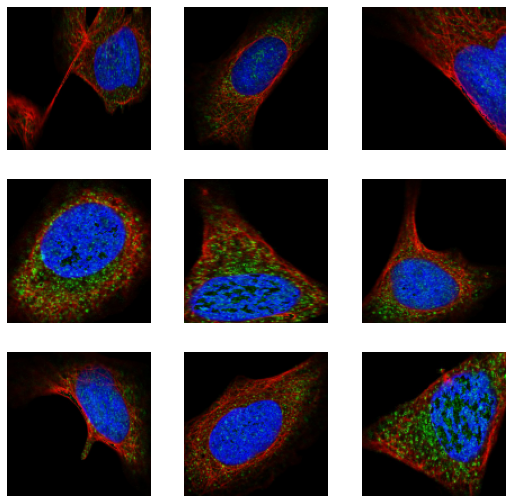

In [64]:
# code to create batch dataset
test_dl = res_learn.dls.test_dl(cell_test_df)
torch.cuda.empty_cache()
test_dl.show_batch()

Predecting labels for cells presents in all test images..

In [65]:
# performing prediction
preds, _ = res_learn.get_preds(dl=test_dl) 

In [66]:
preds.shape

torch.Size([10716, 19])

In [68]:
# saving prediction in a file
with open('preds.pickle', 'wb') as handle:
    pickle.dump(preds, handle)

In [69]:
cls_prds = torch.argmax(preds, dim=-1)
len(cls_prds), cls_prds

(10716, tensor([ 9,  2,  2,  ..., 16, 16, 16]))

Creating submission file..

In [70]:
sample_submission = pd.read_csv('../input/hpa-single-cell-image-classification/sample_submission.csv')
sample_submission.head()

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


In [71]:
# combining predicted labels and encoded string
cell_test_df['cls'] = cls_prds
cell_test_df['pred'] = cell_test_df[['cls', 'enc']].apply(lambda r: str(r[0]) + ' 1 ' + r[1], axis=1)
cell_test_df.head()

,image_id,fname,r_mean,g_mean,b_mean,cell_id,size1,size2,enc,cls,pred
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_1.jpg,0.042343,0.032151,0.073973,1,342,1050,eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJQ3KyD//9t1KPhu1M22Rp9Op0+n0+mM87cMoj1osoHmgDN8aeCormcu7nBXgQ+ehxXWFczA9bDBPaF6ihPHrWECyRR/hTV4ulyuSLqm0GFMxOpDvRP18Ep+tynLSBV1RzGc8BzGg16HSIq67ArBrfnL9Zp2i/y2fHCXkg/EEndH0wZn4nGL83Un/cxvL5z/znmGbR/547j9q357wNPbeTj+eVfOUeZqzsl659RF2iFSDuMhWAaL5B79fB9lpOKPFk7p41Zbv9liAz9nMf6tN/Duxvin3UCiNRH+8lIotTxC7kQpCC2NcO4sU6i0dYSek6TQanGEYyeTMn0domcnOTT6MsSpneaw16MQJ3aeg8t4iI0lcghZG2BhuQUsWB1gbs0KiJgIMLN4ASuWB5hYUQEFiwMMrayAkoUBBlZZwJb5AXJrV4BgXoC+1RRQsUmAnjUuoWEtR9dyS2hZw3FseSVMDcGxNnkJcyPnKMy4BG5sOBZmUsLCWHHMzE0JsRFxTM28hKURcNyY2xJWxpzj2qxKSIwpoYbQmGbHW6nX+hK5W6lX...,9,9 1 eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJQ3KyD//9t1KPhu1M22Rp9Op0+n0+mM87cMoj1osoHmgDN8aeCormcu7nBXgQ+ehxXWFczA9bDBPaF6ihPHrWECyRR/hTV4ulyuSLqm0GFMxOpDvRP18Ep+tynLSBV1RzGc8BzGg16HSIq67ArBrfnL9Zp2i/y2fHCXkg/EEndH0wZn4nGL83Un/cxvL5z/znmGbR/547j9q357wNPbeTj+eVfOUeZqzsl659RF2iFSDuMhWAaL5B79fB9lpOKPFk7p41Zbv9liAz9nMf6tN/Duxvin3UCiNRH+8lIotTxC7kQpCC2NcO4sU6i0dYSek6TQanGEYyeTMn0domcnOTT6MsSpneaw16MQJ3aeg8t4iI0lcghZG2BhuQUsWB1gbs0KiJgIMLN4ASuWB5hYUQEFiwMMrayAkoUBBlZZwJb5AXJrV4BgXoC+1RRQsUmAnjUuoWEtR9dyS2hZw3FseSVMDcGxNnkJcyPnKMy4BG5sOBZmUsLCWHHMzE0JsRFxTM28hKURcNyY2xJWxpzj2qxKSIwpoYbQmGbHW6nX+hK5...
1,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_2.jpg,0.034332,0.027210,0.045968,2,762,680,eNrVUm1PwkAM/kvt3XgRjEajvO7uhGCEEHCgcSQi/v9vXtudbGwzQT+5JteXe67tnna7fE1wC6tPVA5tFGujrDLa+tOhjyixRFcI421kPMKBy6KmEbeG9F7H7QG91+YJd1YqRLEgLu8Ewb5HdGv8kCGFBXXkrdZQ9AGmHEFfVyIXfXQAmEW1aQ/yPqHgd59DOb2AHORK5nocQADn4siaOwZkTrL+hPGAEs6DXRL5Y+G7dCvvaIolHJ+W5xtrV5it0TJ3b0U01bg5Zn2csmxHzudZ2WisbaFeyN/rFPu5uSY2rOp1iBej+h2ZBxMJhGLGgB3yX+JVaqfPbrLAfQKPqT2s3cccpxuy92v3PsfZBp5Su127xMBiibsE3nx1ynp7xRrvu0ZL/Wo9bFXHA/vEzDn+t2TTpxuyLJ7lQ3GzQPLxFvl7xzuV9y0S3qpRo9TfsTNCjxt/+7/a/62R/5I/xHmPf+Br1KzOd7pPp/iwh6f7lsUnD/sZfgE+j18v,2,2 1 eNrVUm1PwkAM/kvt3XgRjEajvO7uhGCEEHCgcSQi/v9vXtudbGwzQT+5JteXe67tnna7fE1wC6tPVA5tFGujrDLa+tOhjyixRFcI421kPMKBy6KmEbeG9F7H7QG91+YJd1YqRLEgLu8Ewb5HdGv8kCGFBXXkrdZQ9AGmHEFfVyIXfXQAmEW1aQ/yPqHgd59DOb2AHORK5nocQADn4siaOwZkTrL+hPGAEs6DXRL5Y+G7dCvvaIolHJ+W5xtrV5it0TJ3b0U01bg5Zn2csmxHzudZ2WisbaFeyN/rFPu5uSY2rOp1iBej+h2ZBxMJhGLGgB3yX+JVaqfPbrLAfQKPqT2s3cccpxuy92v3PsfZBp5Su127xMBiibsE3nx1ynp7xRrvu0ZL/Wo9bFXHA/vEzDn+t2TTpxuyLJ7lQ3GzQPLxFvl7xzuV9y0S3qpRo9TfsTNCjxt/+7/a/62R/5I/xHmPf+Br1KzOd7pPp/iwh6f7lsUnD/sZfgE+j18v
2,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_3.jpg,0.093926,0.033953,0.078939,3,398,470,eNoLCEgJMg4wDMg3NPQ39Df2NfaF0EZ+IBoBIXzc8oSgARxA2OiiuMWJBYT0kyuPLk4aH+F/6ojTS57a5tALwtIpqemTVvYDaQMDIwM/eJoCiQJJXO4EhqCBPyQ8/Yz8DbAlLScA3+jcjQ==,2,2 1 eNoLCEgJMg4wDMg3NPQ39Df2NfaF0EZ+IBoBIXzc8oSgARxA2OiiuMWJBYT0kyuPLk4aH+F/6ojTS57a5tALwtIpqemTVvYDaQMDIwM/eJoCiQJJXO4EhqCBPyQ8/Yz8DbAlLScA3+jcjQ==
3,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_4.jpg,0.120287,0.085569,0.099383,4,372,344,eNptUstOAzEM/CUnXtoiAQcegnbzOMAFgdRFbIXEpf9/q+2pd0vYjZQde8aPxBmHz4EG2h9DLDGtHg5hLIJK198+muf+i7YKusQ11JD5vf5QjUXQ041KE+9WagsbLVRRu1re9sKI769qIHKt+hyhDnRzXvCZMy/zrU76W/R7Ha1N5B3Mnfii6RMsDgHqrbrDINWc7SnExJf6i0RzsaY42iNkXdChJbXswK3er3jiEedHEZXzgv7ni/P1GAq5U32O55FFjAeKIgPowXPBcDmjfoSdO/D2eOw17dTmhIGx+l0v/Qj7l3+5hv28Sfpf7+sdHB91JHO9fb/+xhOdSqvy,16,16 1 eNptUstOAzEM/CUnXtoiAQcegnbzOMAFgdRFbIXEpf9/q+2pd0vYjZQde8aPxBmHz4EG2h9DLDGtHg5hLIJK198+muf+i7YKusQ11JD5vf5QjUXQ041KE+9WagsbLVRRu1re9sKI769qIHKt+hyhDnRzXvCZMy/zrU76W/R7Ha1N5B3Mnfii6RMsDgHqrbrDINWc7SnExJf6i0RzsaY42iNkXdChJbXswK3er3jiEedHEZXzgv7ni/P1GAq5U32O55FFjAeKIgPowXPBcDmjfoSdO/D2eOw17dTmhIGx+l0v/Qj7l3+5hv28Sfpf7+sdHB91JHO9fb/+xhOdSqvy
4,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0040581b-f1f2-4fbe-b043-b6bfea5404bb_5.jpg,0.088759,0.076198,0.077768,5,544,244,eNp9UcuSmzAQ/CVGku1U8CGpxBs7EsMrPNdgMNYasIH/v0UD61RctbXo0D2tHqk1/Okvr5Dw9g4MmRL7Lzjjt8payE/bZQgO323nmu9sF1xTdy+ZOmvMRZFDK2

In [72]:
# Grouping Cells records into their Image records from where segmented cells were cropped.
subm = cell_test_df.groupby(['image_id'])['pred'].apply(lambda x: ' '.join(x)).reset_index()
subm.head()

,image_id,pred
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,9 1 eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJQ3KyD//9t1KPhu1M22Rp9Op0+n0+mM87cMoj1osoHmgDN8aeCormcu7nBXgQ+ehxXWFczA9bDBPaF6ihPHrWECyRR/hTV4ulyuSLqm0GFMxOpDvRP18Ep+tynLSBV1RzGc8BzGg16HSIq67ArBrfnL9Zp2i/y2fHCXkg/EEndH0wZn4nGL83Un/cxvL5z/znmGbR/547j9q357wNPbeTj+eVfOUeZqzsl659RF2iFSDuMhWAaL5B79fB9lpOKPFk7p41Zbv9liAz9nMf6tN/Duxvin3UCiNRH+8lIotTxC7kQpCC2NcO4sU6i0dYSek6TQanGEYyeTMn0domcnOTT6MsSpneaw16MQJ3aeg8t4iI0lcghZG2BhuQUsWB1gbs0KiJgIMLN4ASuWB5hYUQEFiwMMrayAkoUBBlZZwJb5AXJrV4BgXoC+1RRQsUmAnjUuoWEtR9dyS2hZw3FseSVMDcGxNnkJcyPnKMy4BG5sOBZmUsLCWHHMzE0JsRFxTM28hKURcNyY2xJWxpzj2qxKSIwpoYbQmGbHW6nX+hK5...
1,004a270d-34a2-4d60-bbe4-365fca868193,16 1 eNoLCEhJMAgwDMg3NPQ39Df2tXaF0PaOENrYF0Kbe6LyrdxAtKG/kR+Eb+aFyoeZA1OPLg+hcUMDAxAGkRAeJp9yALEKwsInjspHdyoheWLV43IPbnnS7MUO/Yz8jJBt8Db1NYaIE9IHUedqjareywzC9zSH0MAEAKIDA2JyjADDeJGw 16 1 eNqFUmlvwjAM/Ut+dBpDbNohsa3b6kiQpqIMxNaukJTj/39bD0IbTluK/Z4dO4cTqZTXT7eAKLXDCDzRqXwiEqBqLflqLSMN29LAm4nfHbfbTPVqBeIKXzWhsraoyV2C2IN24wYXkn09yYjntFrieRTx43qJl2HED9slXjeKeyMNzhRjokGpYvrWQKJYTDVu5oo/fzTuJor9v8LGit8zjd5Y8dtC4z5UPMg1MtIhT0RkCm8RcixigwWlIY/F1MDQLORIJAYSW8kbHuYYYVV6svSM5DVHORQSySue5TAd9wr7d7HvYZ/2HF9/iRfUtsFe4NrbDzfe9d34Ibb1rvWnI3HzLsmJLzyaqEYP809ncT2drR3FJFe8jde4uGhl/a6LB30XW9tUvXyudualc57Xa6N+P...
2,00537262-883c-4b37-a3a1-a4931b6faea5,14 1 eNqFUE0LwjAM/UtJuqlM8AsUN9fWgzcVlDEPMvD/32yS1m2IuLC8vOSlafM4dlC0LySP3tQn7Bw58sbOt8gZu1wrTkvFBq5eozO2TqOgBYDQZwMH+miNVSTRoQ8ourxiHXhyX/UR/2uOxMeTg2dDZxjrrM4S/ugH4J99Yj+Nr13syIlchoWh0gRcFCfB8NNkSie95D2PxsiGYwb68UUxTuPlUP/4tAh9elqB18i4WOETmB9kJdZEJa+670zdoS6rC94mbrhW59q/nwnPy0klfHUDSUxWC0lkG8X7s7mYNwcdlKw= 14 1 eNqtVFFTwyAM/ksJ7VrPF88Xte0augfnbXYv6py77c7//yaQsQKl27UOeqRJPgL5AjRN2+IXtL+IEmVSH+BV8l9Sx6UeQTWU/Mey37Unhhtrn9oF+fvOC5YPj77+CZsg46z0I7C83sMM+rptQwxM80/U81KQElKcAiMlBDpt1mVWGT+Imu33z4xXQUDqYODPh/NWwX6orFlplzSxz1sg9BnRfEOvDdmHcAE+pAC6uoY18eIgb7Gbp/OGGzaJJLqjE0NUM/bEvNpTJ8wnMf/4kkeQC...
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,7 1 eNrtVUtvwjAM/ktxAutp2mGXDhpHGpDCxvuZQtn+/21OnZQCEkyaNO2wWIqftROr/lL0bQ+eFp+gNKAkAiEM7YYIpd+1Yn4iiuAoifyV4vjKwlalH59bXf+dzJTfOR95SEIIFap65KvyiWA/q0+SbnXadT3SqRpHhZp0vocO5YiW2hNJAOev/eJal6bdBX8b1uNqxPlzK02nPIuICbSK5opf5r9c9/z3luH7Vh0xtwLB8F71Ia5Zjtt07OAtWf9M2qXvDkbJJsePtO/gNSl/WzqmAwe95JBjmVoH/WT/L/1JaZA4Lw0dTJPv/+ZhhLUUIJpzfRq3xjiBuRwoBq7bFW44PYydA4qPbwxSc47F2dyHvCjD8NXBgK1MYoBDE0c0wmdVL8LfLTohT5Su9bqkPzajYNCNYGgts4nFzqYAubDYnReglhazGekri3pagNlZFKMCsoNFZQvolhZbgwI6R+bpMEcsHOAkR7N2YKY5ihXpM+Z6kSPMiS9zlDMH2arBxyW8cDPChQVhvW+AfyWqFvH7sHXHPXwBvVrJXQ== 7 1 eNpVU3tzmzAM/0qWMdBr2t31mt0CNnK2QZ6...
4,0173029a-161d-40ef-af28-2342915b22fb,16 1 eNqtlFuXmjAQgP8SDOgB2peeLsueXccgbgWRiwKRYBf2/781AYOKaN2eJmq+uSSZTCYqq51ySEDhTSXdr+hyvN1v+Q/117JsX9U/an+oVRlGMfFiKDKlkUwz5aPl9xiqTCGTN+ke/EgL3GE+p2YTQflCC0y4xEwWQfVSFhhzqTL3QqoKjLj028wj2DtViWvDD6Bw6hI3xlJQU2JkeAHkjss4uQHsnCXD1Kh9SJwVw8w4+BA7gSAmaM0wN0ofVs6W4cHY+rB0coa1EfvgCfoU5DoFQ9dcpaAQReVht/khIC9N5o7r1C/mq5sglzndxKh+xJ904cx0Me1f97tuczg5jJ1tFm/w8FQU8OubPl5LfQ2pP9cbTG1WQGqFG9zapSCu2/UU2qqyL2AveG1rChUcCP0tXlCg1meIG9ujUFhNiJG9pJBbdYjxKL1TyKyPEJMhTQcPavgcYH7+OIde44cPQqztPQXXCkN0n0sKn+Y6xMUzo9CY3OqdkabEgrf3OaFQm2mIy2tuzFjwhHD2rCzExr5PWwoLKxGR5RRW1ums8uL4VyUaPlLA3G9+nRvUumrhI5CL6uMftRvEW5K...


In [73]:
sub = pd.merge(sample_submission,subm,how="left",left_on='ID',right_on='image_id')
sub.head()

,ID,ImageWidth,ImageHeight,PredictionString,image_id,pred
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0040581b-f1f2-4fbe-b043-b6bfea5404bb,9 1 eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJQ3KyD//9t1KPhu1M22Rp9Op0+n0+mM87cMoj1osoHmgDN8aeCormcu7nBXgQ+ehxXWFczA9bDBPaF6ihPHrWECyRR/hTV4ulyuSLqm0GFMxOpDvRP18Ep+tynLSBV1RzGc8BzGg16HSIq67ArBrfnL9Zp2i/y2fHCXkg/EEndH0wZn4nGL83Un/cxvL5z/znmGbR/547j9q357wNPbeTj+eVfOUeZqzsl659RF2iFSDuMhWAaL5B79fB9lpOKPFk7p41Zbv9liAz9nMf6tN/Duxvin3UCiNRH+8lIotTxC7kQpCC2NcO4sU6i0dYSek6TQanGEYyeTMn0domcnOTT6MsSpneaw16MQJ3aeg8t4iI0lcghZG2BhuQUsWB1gbs0KiJgIMLN4ASuWB5hYUQEFiwMMrayAkoUBBlZZwJb5AXJrV4BgXoC+1RRQsUmAnjUuoWEtR9dyS2hZw3FseSVMDcGxNnkJcyPnKMy4BG5sOBZmUsLCWHHMzE0JsRFxTM28hKURcNyY2xJWxpzj2qxKSIwpoYbQmGbHW6nX+hK5...
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,004a270d-34a2-4d60-bbe4-365fca868193,16 1 eNoLCEhJMAgwDMg3NPQ39Df2tXaF0PaOENrYF0Kbe6LyrdxAtKG/kR+Eb+aFyoeZA1OPLg+hcUMDAxAGkRAeJp9yALEKwsInjspHdyoheWLV43IPbnnS7MUO/Yz8jJBt8Db1NYaIE9IHUedqjareywzC9zSH0MAEAKIDA2JyjADDeJGw 16 1 eNqFUmlvwjAM/Ut+dBpDbNohsa3b6kiQpqIMxNaukJTj/39bD0IbTluK/Z4dO4cTqZTXT7eAKLXDCDzRqXwiEqBqLflqLSMN29LAm4nfHbfbTPVqBeIKXzWhsraoyV2C2IN24wYXkn09yYjntFrieRTx43qJl2HED9slXjeKeyMNzhRjokGpYvrWQKJYTDVu5oo/fzTuJor9v8LGit8zjd5Y8dtC4z5UPMg1MtIhT0RkCm8RcixigwWlIY/F1MDQLORIJAYSW8kbHuYYYVV6svSM5DVHORQSySue5TAd9wr7d7HvYZ/2HF9/iRfUtsFe4NrbDzfe9d34Ibb1rvWnI3HzLsmJLzyaqEYP809ncT2drR3FJFe8jde4uGhl/a6LB30XW9tUvXyudualc57Xa6N+P...
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,00537262-883c-4b37-a3a1-a4931b6faea5,14 1 eNqFUE0LwjAM/UtJuqlM8AsUN9fWgzcVlDEPMvD/32yS1m2IuLC8vOSlafM4dlC0LySP3tQn7Bw58sbOt8gZu1wrTkvFBq5eozO2TqOgBYDQZwMH+miNVSTRoQ8ourxiHXhyX/UR/2uOxMeTg2dDZxjrrM4S/ugH4J99Yj+Nr13syIlchoWh0gRcFCfB8NNkSie95D2PxsiGYwb68UUxTuPlUP/4tAh9elqB18i4WOETmB9kJdZEJa+670zdoS6rC94mbrhW59q/nwnPy0klfHUDSUxWC0lkG8X7s7mYNwcdlKw= 14 1 eNqtVFFTwyAM/ksJ7VrPF88Xte0augfnbXYv6py77c7//yaQsQKl27UOeqRJPgL5AjRN2+IXtL+IEmVSH+BV8l9Sx6UeQTWU/Mey37Unhhtrn9oF+fvOC5YPj77+CZsg46z0I7C83sMM+rptQwxM80/U81KQElKcAiMlBDpt1mVWGT+Imu33z4xXQUDqYODPh/NWwX6orFlplzSxz1sg9BnRfEOvDdmHcAE+pAC6uoY18eIgb7Gbp/OGGzaJJLqjE0NUM/bEvNpTJ8wnMf/4kkeQC...
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,00c9a1c9-2f06-476f-8b0d-6d01032874a2,7 1 eNrtVUtvwjAM/ktxAutp2mGXDhpHGpDCxvuZQtn+/21OnZQCEkyaNO2wWIqftROr/lL0bQ+eFp+gNKAkAiEM7YYIpd+1Yn4iiuAoifyV4vjKwlalH59bXf+dzJTfOR95SEIIFap65KvyiWA/q0+SbnXadT3SqRpHhZp0vocO5YiW2hNJAOev/eJal6bdBX8b1uNqxPlzK02nPIuICbSK5opf5r9c9/z3luH7Vh0xtwLB8F71Ia5Zjtt07OAtWf9M2qXvDkbJJsePtO/gNSl/WzqmAwe95JBjmVoH/WT/L/1JaZA4Lw0dTJPv/+ZhhLUUIJpzfRq3xjiBuRwoBq7bFW44PYydA4qPbwxSc47F2dyHvCjD8NXBgK1MYoBDE0c0wmdVL8LfLTohT5Su9bqkPzajYNCNYGgts4nFzqYAubDYnReglhazGekri3pagNlZFKMCsoNFZQvolhZbgwI6R+bpMEcsHOAkR7N2YKY5ihXpM+Z6kSPMiS9zlDMH2arBxyW8cDPChQVhvW+AfyWqFvH7sHXHPXwBvVrJXQ== 7 1 eNpVU3tzmzAM/0qWMdBr2t31mt0CNnK2QZ6...
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==,0173029a-161d-40ef-af28-2342915b22fb,16 1 eNqtlFuXmjAQgP8SDOgB2peeLsueXccgbgWRiwKRYBf2/781AYOKaN2eJmq+uSSZTCYqq51ySEDhTSXdr+hyvN1v+Q/117JsX9U/an+oVRlGMfFiKDKlkUwz5aPl9xiqTCGTN+ke/EgL3GE+p2YTQflCC0y4xEwWQfVSFhhzqTL3QqoKjLj028wj2DtViWvDD6Bw6hI3xlJQU2JkeAHkjss4uQHsnCXD1Kh9SJwVw8w4+BA7gSAmaM0wN0ofVs6W4cHY+rB0coa1EfvgCfoU5DoFQ9dcpaAQReVht/khIC9N5o7r1C/mq5sglzndxKh+xJ904cx0Me1f97tuczg5jJ1tFm/w8FQU8OubPl5LfQ2pP9cbTG1WQGqFG9zapSCu2/UU2qqyL2AveG1rChUcCP0tXlCg1meIG9ujUFhNiJG9pJBbdYjxKL1TyKyPEJMhTQcPavgcYH7+OIde44cPQqztPQXXCkN0n0sKn+Y6xMUzo9CY3OqdkabEgrf3OaFQm2mIy2tuzFjwhHD2rCzExr5PWwoLKxGR5RRW1ums8uL4VyUaPlLA3G9+nRvUumrhI5CL6uMftRvEW5K...


In [74]:
def isNaN(num):
    return num != num

for i, row in sub.iterrows():
    if isNaN(row['pred']): continue
    sub.PredictionString.loc[i] = row['pred']

In [75]:
sub = sub[sample_submission.columns]
sub.head()

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,9 1 eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJQ3KyD//9t1KPhu1M22Rp9Op0+n0+mM87cMoj1osoHmgDN8aeCormcu7nBXgQ+ehxXWFczA9bDBPaF6ihPHrWECyRR/hTV4ulyuSLqm0GFMxOpDvRP18Ep+tynLSBV1RzGc8BzGg16HSIq67ArBrfnL9Zp2i/y2fHCXkg/EEndH0wZn4nGL83Un/cxvL5z/znmGbR/547j9q357wNPbeTj+eVfOUeZqzsl659RF2iFSDuMhWAaL5B79fB9lpOKPFk7p41Zbv9liAz9nMf6tN/Duxvin3UCiNRH+8lIotTxC7kQpCC2NcO4sU6i0dYSek6TQanGEYyeTMn0domcnOTT6MsSpneaw16MQJ3aeg8t4iI0lcghZG2BhuQUsWB1gbs0KiJgIMLN4ASuWB5hYUQEFiwMMrayAkoUBBlZZwJb5AXJrV4BgXoC+1RRQsUmAnjUuoWEtR9dyS2hZw3FseSVMDcGxNnkJcyPnKMy4BG5sOBZmUsLCWHHMzE0JsRFxTM28hKURcNyY2xJWxpzj2qxKSIwpoYbQmGbHW6nX+hK5...
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,16 1 eNoLCEhJMAgwDMg3NPQ39Df2tXaF0PaOENrYF0Kbe6LyrdxAtKG/kR+Eb+aFyoeZA1OPLg+hcUMDAxAGkRAeJp9yALEKwsInjspHdyoheWLV43IPbnnS7MUO/Yz8jJBt8Db1NYaIE9IHUedqjareywzC9zSH0MAEAKIDA2JyjADDeJGw 16 1 eNqFUmlvwjAM/Ut+dBpDbNohsa3b6kiQpqIMxNaukJTj/39bD0IbTluK/Z4dO4cTqZTXT7eAKLXDCDzRqXwiEqBqLflqLSMN29LAm4nfHbfbTPVqBeIKXzWhsraoyV2C2IN24wYXkn09yYjntFrieRTx43qJl2HED9slXjeKeyMNzhRjokGpYvrWQKJYTDVu5oo/fzTuJor9v8LGit8zjd5Y8dtC4z5UPMg1MtIhT0RkCm8RcixigwWlIY/F1MDQLORIJAYSW8kbHuYYYVV6svSM5DVHORQSySue5TAd9wr7d7HvYZ/2HF9/iRfUtsFe4NrbDzfe9d34Ibb1rvWnI3HzLsmJLzyaqEYP809ncT2drR3FJFe8jde4uGhl/a6LB30XW9tUvXyudualc57Xa6N+P...
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,14 1 eNqFUE0LwjAM/UtJuqlM8AsUN9fWgzcVlDEPMvD/32yS1m2IuLC8vOSlafM4dlC0LySP3tQn7Bw58sbOt8gZu1wrTkvFBq5eozO2TqOgBYDQZwMH+miNVSTRoQ8ourxiHXhyX/UR/2uOxMeTg2dDZxjrrM4S/ugH4J99Yj+Nr13syIlchoWh0gRcFCfB8NNkSie95D2PxsiGYwb68UUxTuPlUP/4tAh9elqB18i4WOETmB9kJdZEJa+670zdoS6rC94mbrhW59q/nwnPy0klfHUDSUxWC0lkG8X7s7mYNwcdlKw= 14 1 eNqtVFFTwyAM/ksJ7VrPF88Xte0augfnbXYv6py77c7//yaQsQKl27UOeqRJPgL5AjRN2+IXtL+IEmVSH+BV8l9Sx6UeQTWU/Mey37Unhhtrn9oF+fvOC5YPj77+CZsg46z0I7C83sMM+rptQwxM80/U81KQElKcAiMlBDpt1mVWGT+Imu33z4xXQUDqYODPh/NWwX6orFlplzSxz1sg9BnRfEOvDdmHcAE+pAC6uoY18eIgb7Gbp/OGGzaJJLqjE0NUM/bEvNpTJ8wnMf/4kkeQC...
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,7 1 eNrtVUtvwjAM/ktxAutp2mGXDhpHGpDCxvuZQtn+/21OnZQCEkyaNO2wWIqftROr/lL0bQ+eFp+gNKAkAiEM7YYIpd+1Yn4iiuAoifyV4vjKwlalH59bXf+dzJTfOR95SEIIFap65KvyiWA/q0+SbnXadT3SqRpHhZp0vocO5YiW2hNJAOev/eJal6bdBX8b1uNqxPlzK02nPIuICbSK5opf5r9c9/z3luH7Vh0xtwLB8F71Ia5Zjtt07OAtWf9M2qXvDkbJJsePtO/gNSl/WzqmAwe95JBjmVoH/WT/L/1JaZA4Lw0dTJPv/+ZhhLUUIJpzfRq3xjiBuRwoBq7bFW44PYydA4qPbwxSc47F2dyHvCjD8NXBgK1MYoBDE0c0wmdVL8LfLTohT5Su9bqkPzajYNCNYGgts4nFzqYAubDYnReglhazGekri3pagNlZFKMCsoNFZQvolhZbgwI6R+bpMEcsHOAkR7N2YKY5ihXpM+Z6kSPMiS9zlDMH2arBxyW8cDPChQVhvW+AfyWqFvH7sHXHPXwBvVrJXQ== 7 1 eNpVU3tzmzAM/0qWMdBr2t31mt0CNnK2QZ6...
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,16 1 eNqtlFuXmjAQgP8SDOgB2peeLsueXccgbgWRiwKRYBf2/781AYOKaN2eJmq+uSSZTCYqq51ySEDhTSXdr+hyvN1v+Q/117JsX9U/an+oVRlGMfFiKDKlkUwz5aPl9xiqTCGTN+ke/EgL3GE+p2YTQflCC0y4xEwWQfVSFhhzqTL3QqoKjLj028wj2DtViWvDD6Bw6hI3xlJQU2JkeAHkjss4uQHsnCXD1Kh9SJwVw8w4+BA7gSAmaM0wN0ofVs6W4cHY+rB0coa1EfvgCfoU5DoFQ9dcpaAQReVht/khIC9N5o7r1C/mq5sglzndxKh+xJ904cx0Me1f97tuczg5jJ1tFm/w8FQU8OubPl5LfQ2pP9cbTG1WQGqFG9zapSCu2/UU2qqyL2AveG1rChUcCP0tXlCg1meIG9ujUFhNiJG9pJBbdYjxKL1TyKyPEJMhTQcPavgcYH7+OIde44cPQqztPQXXCkN0n0sKn+Y6xMUzo9CY3OqdkabEgrf3OaFQm2mIy2tuzFjwhHD2rCzExr5PWwoLKxGR5RRW1ums8uL4VyUaPlLA3G9+nRvUumrhI5CL6uMftRvEW5K...


In [76]:
sub.to_csv('submission.csv', index=False)

### Model Performance on Test data or unseen data

To check the performance of the model we need labeled and unseen data. So we will use 25 records for each label from training data which we have already seperated from train data before training.

In [120]:
test_performance_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2,0,1,...,9,10,11,12,13,14,15,16,17,18
0,96971788-bbc3-11e8-b2bc-ac1f6b6435d0,0.058740,0.097258,0.048798,17,0,314,241,1,0,...,0,0,0,0,0,0,0,0,0,0
1,57c12c30-bba3-11e8-b2b9-ac1f6b6435d0,0.049480,0.023562,0.097921,17,0,467,531,1,0,...,0,0,0,0,0,0,0,0,0,0
2,6f062840-bba9-11e8-b2ba-ac1f6b6435d0,0.065905,0.014036,0.038552,18,0,476,456,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9a92003a-bbc0-11e8-b2bb-ac1f6b6435d0,0.006112,0.013585,0.004849,3,0,249,352,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4b153af0-bbc4-11e8-b2bc-ac1f6b6435d0,0.004491,0.052781,0.068927,20,0,356,474,1,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
test_performance_df.shape

(475, 27)

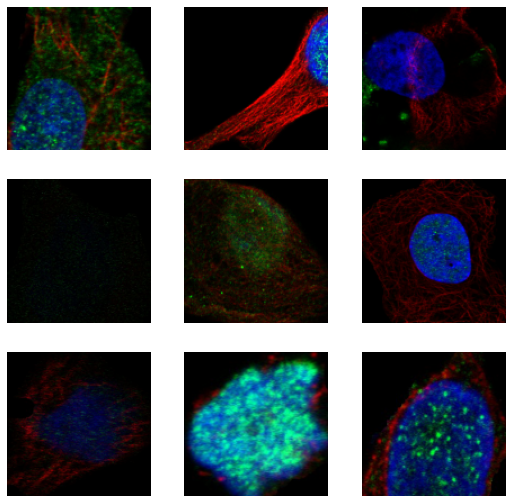

In [122]:
# code to create batch dataset
test_dl = res_learn.dls.test_dl(test_performance_df)
torch.cuda.empty_cache()
test_dl.show_batch()

In [123]:
# performing predictions
predictions, _ = res_learn.get_preds(dl=test_dl)

In [124]:
print(predictions)

tensor([[0.2217, 0.1294, 0.0249,  ..., 0.0429, 0.0055, 0.0058],
        [0.4745, 0.0137, 0.0230,  ..., 0.0075, 0.0722, 0.0007],
        [0.0222, 0.0110, 0.0052,  ..., 0.0300, 0.0085, 0.0017],
        ...,
        [0.0663, 0.0279, 0.0267,  ..., 0.3189, 0.0228, 0.0015],
        [0.0106, 0.0008, 0.0729,  ..., 0.0051, 0.0446, 0.0203],
        [0.0637, 0.0165, 0.0370,  ..., 0.1434, 0.0498, 0.0056]])


In [125]:
# Converting predicted probabilites into class labels
cls_predictions = torch.argmax(predictions, dim=-1)
len(cls_predictions), cls_predictions

(475,
 tensor([ 5,  0, 13,  3,  0,  4,  5,  0,  5,  7, 12,  0,  5, 13,  2, 15,  0,  4,
          0, 12,  5,  1,  0,  7, 16,  1, 12,  1,  1,  1,  1,  1,  7,  1,  1,  1,
          7,  1,  7,  1, 14,  1,  1,  0,  1,  1,  1,  1,  1,  1,  3,  2,  3,  3,
          2,  7,  2,  5,  2,  2,  5,  2,  2,  2,  2,  2, 17, 17,  2,  2,  3, 12,
         14,  3,  2,  3,  3,  0,  3,  3,  3,  3, 12,  3,  2,  3,  6,  0,  3, 12,
          4,  3, 16,  3,  3,  5,  3,  3,  3,  5,  4,  7,  4,  3,  4,  4,  4,  5,
          4, 13,  4, 17,  4,  3,  4,  2,  4,  0,  4,  4,  4,  4,  3,  4,  4, 13,
          5,  5, 13, 12,  0,  3,  5,  5,  5,  5,  5,  2, 14,  3,  5,  5, 17,  7,
          5, 14,  5,  5,  7,  5, 16, 14,  6, 16, 13,  6,  6,  6,  6, 16, 16,  6,
          6,  6, 10,  6,  6, 16, 13,  6, 16, 16,  6,  6, 16,  7,  7,  7,  7,  7,
          7,  7,  7,  8,  7,  7,  8,  7,  7,  7,  5,  7,  7,  7, 12,  7,  7,  7,
         12,  7,  8,  2,  8,  8,  6,  8, 14,  8,  8,  9, 16,  8,  9,  8,  8,  8,
          8,  5, 12,  

In [126]:
cls_predictions = np.array(cls_predictions)

In [142]:
from sklearn.metrics  import accuracy_score, confusion_matrix

In [128]:
# Calculating accuracy score
true_label = [int(i) for i in test_performance_df['image_labels']]
accuracy_score(true_label, cls_predictions)

0.5326315789473685

We have got 53.26% accuracy which is less. This is because we have trained our model only on 20% of given training data due system limitation. To increase the prediction accuracy train the model on whole training dataset.

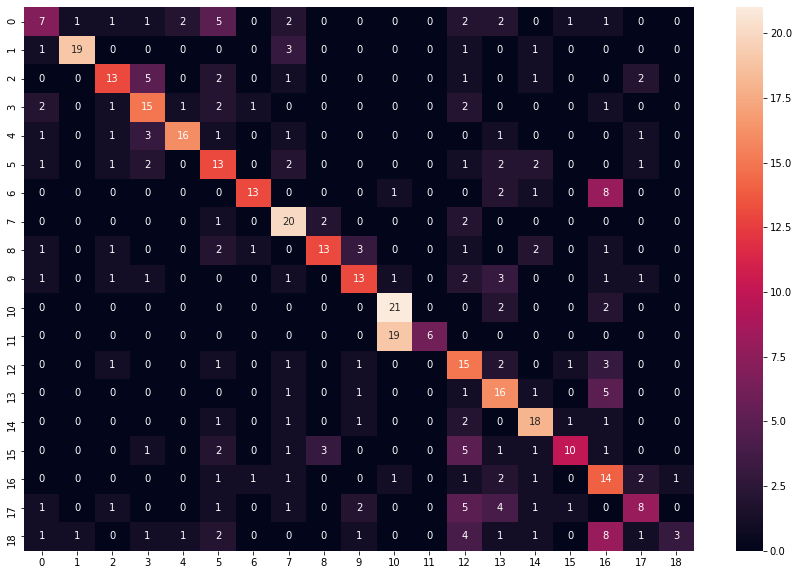

In [141]:
# Plotting confusion matrix to check the prediction accuracy for each class

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
cfm = confusion_matrix(true_label, cls_predictions)
sns.heatmap(cfm, annot=True)
plt.show()

**Let's  interpret the  confusion matrix**  
1. For class label '0'    
Out of 25 reocrds 7 records are predicted correctly. Means 28% accuracy for class '0'.
2. For class label '1'   
Out of 25 reocrds 19 records are predicted correctly. Means 76% accuracy for class '1'.
3. For class label '2'    
Out of 25 reocrds 13 records are predicted correctly. Means 52% accuracy for class '2'.    
    
and so on....

#### NOTE:- we have trained our model only on 20% of given training data due system limitation. To increase the prediction accuracy train the model on whole training dataset.